In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as matp

## General visualizations of Eye tracker data health

In [2]:
data_frame = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [3]:
my_categories = {'Global_Landmark': '#e2514a', 
                 'TaskBuilding_Public': '#fca55d',
                'TaskBuilding_Residential': '#fee999',
                'Active_Agent': '#a2d9a4',
                'Passive_Agent': '#47a0b3'}

In [4]:
data_frame.head()

,Unnamed: 0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,...,corrected_vel,events,length,distance,avg_dist,names,Collider_CategoricalN,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1
0,0,0,479,2,1,1.653045e+09,3,-59.134151,2.259476,34.714977,...,NaN,NaN,NaN,NaN,NaN,Building_161,Building,NaN,NaN,NaN
1,1,1,479,2,1,1.653045e+09,3,-59.134151,2.259476,34.714977,...,NaN,2.0,0.011905,62.645712,62.645712,Building_161,Building,NaN,NaN,NaN
2,2,2,479,2,1,1.653045e+09,3,-59.134151,2.259476,34.714977,...,NaN,-2.0,0.011905,62.645712,62.645712,Building_161,Building,NaN,NaN,NaN
3,3,3,479,2,1,1.653045e+09,3,-59.138134,2.259230,34.714943,...,27.383014,-1.0,0.011408,NaN,NaN,Building_161,Building,NaN,NaN,NaN
4,4,4,479,2,1,1.653045e+09,3,-59.138134,2.259230,34.714912,...,3.578448,2.0,0.254944,62.709433,62.709424,Building_161,Building,NaN,NaN,NaN


In [5]:
# We are excluding two participants because they were exposed to Vincent's experiment
Mask_IDs = data_frame['SubjectID'].isin([ 5238, 8695])
data_frame = data_frame.loc[~Mask_IDs]

In [6]:
data_frame.combinedGazeValidityBitmask.value_counts(normalize=True)

3    0.939948
0    0.060052
Name: combinedGazeValidityBitmask, dtype: float64

In [7]:
Blinks = pd.DataFrame(data_frame.groupby(["SubjectID", "Session"])["combinedGazeValidityBitmask"].value_counts(normalize=True))
Blinks.rename(columns ={"combinedGazeValidityBitmask": "Percentage"}, inplace=True)
Blinks.reset_index(inplace=True)
Blinks.loc[:, 'Validity'] = Blinks['combinedGazeValidityBitmask'].replace( {3:"Valid", 0:"Invalid"})

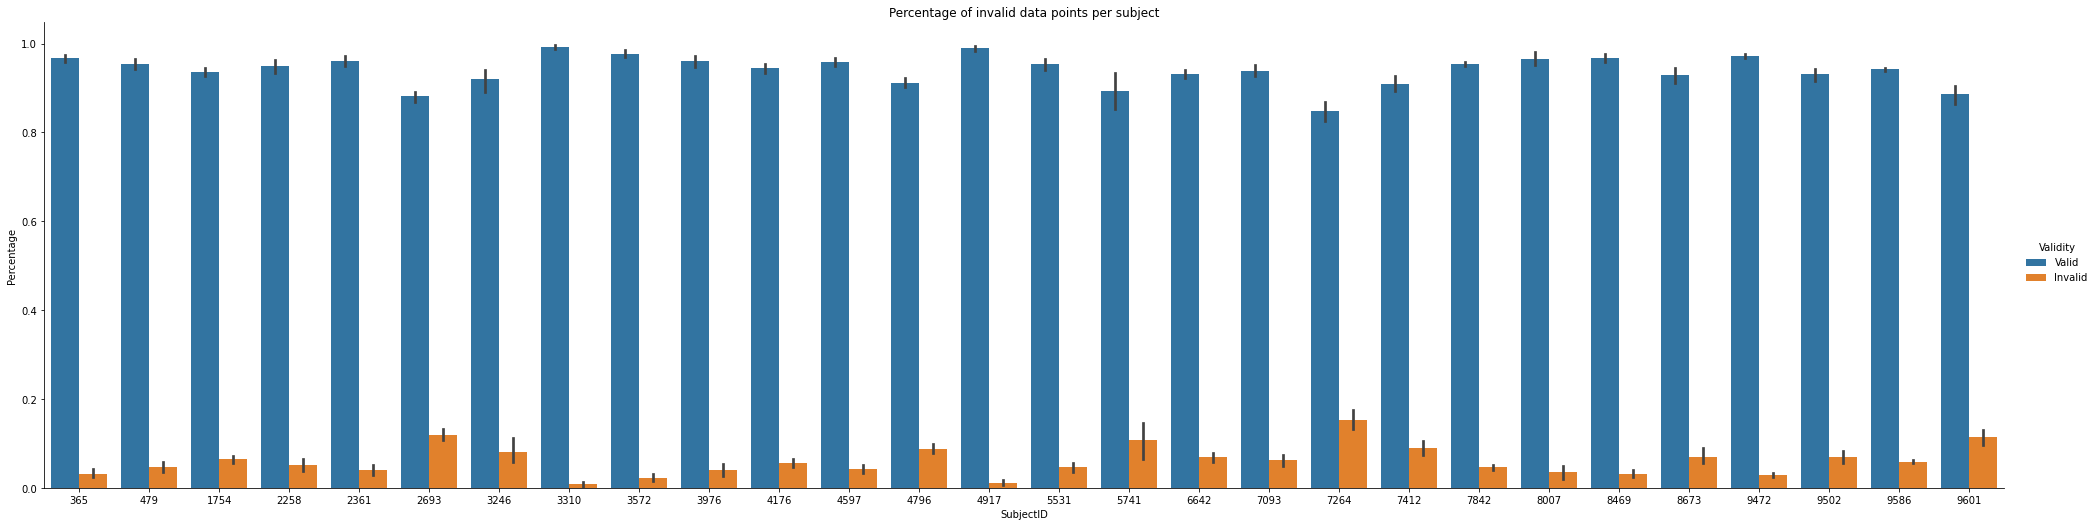

In [8]:
sns.catplot(data=Blinks, hue="Validity", y="Percentage", x="SubjectID", kind="bar", \
            height=7, aspect=4).set(title="Percentage of invalid data points per subject")

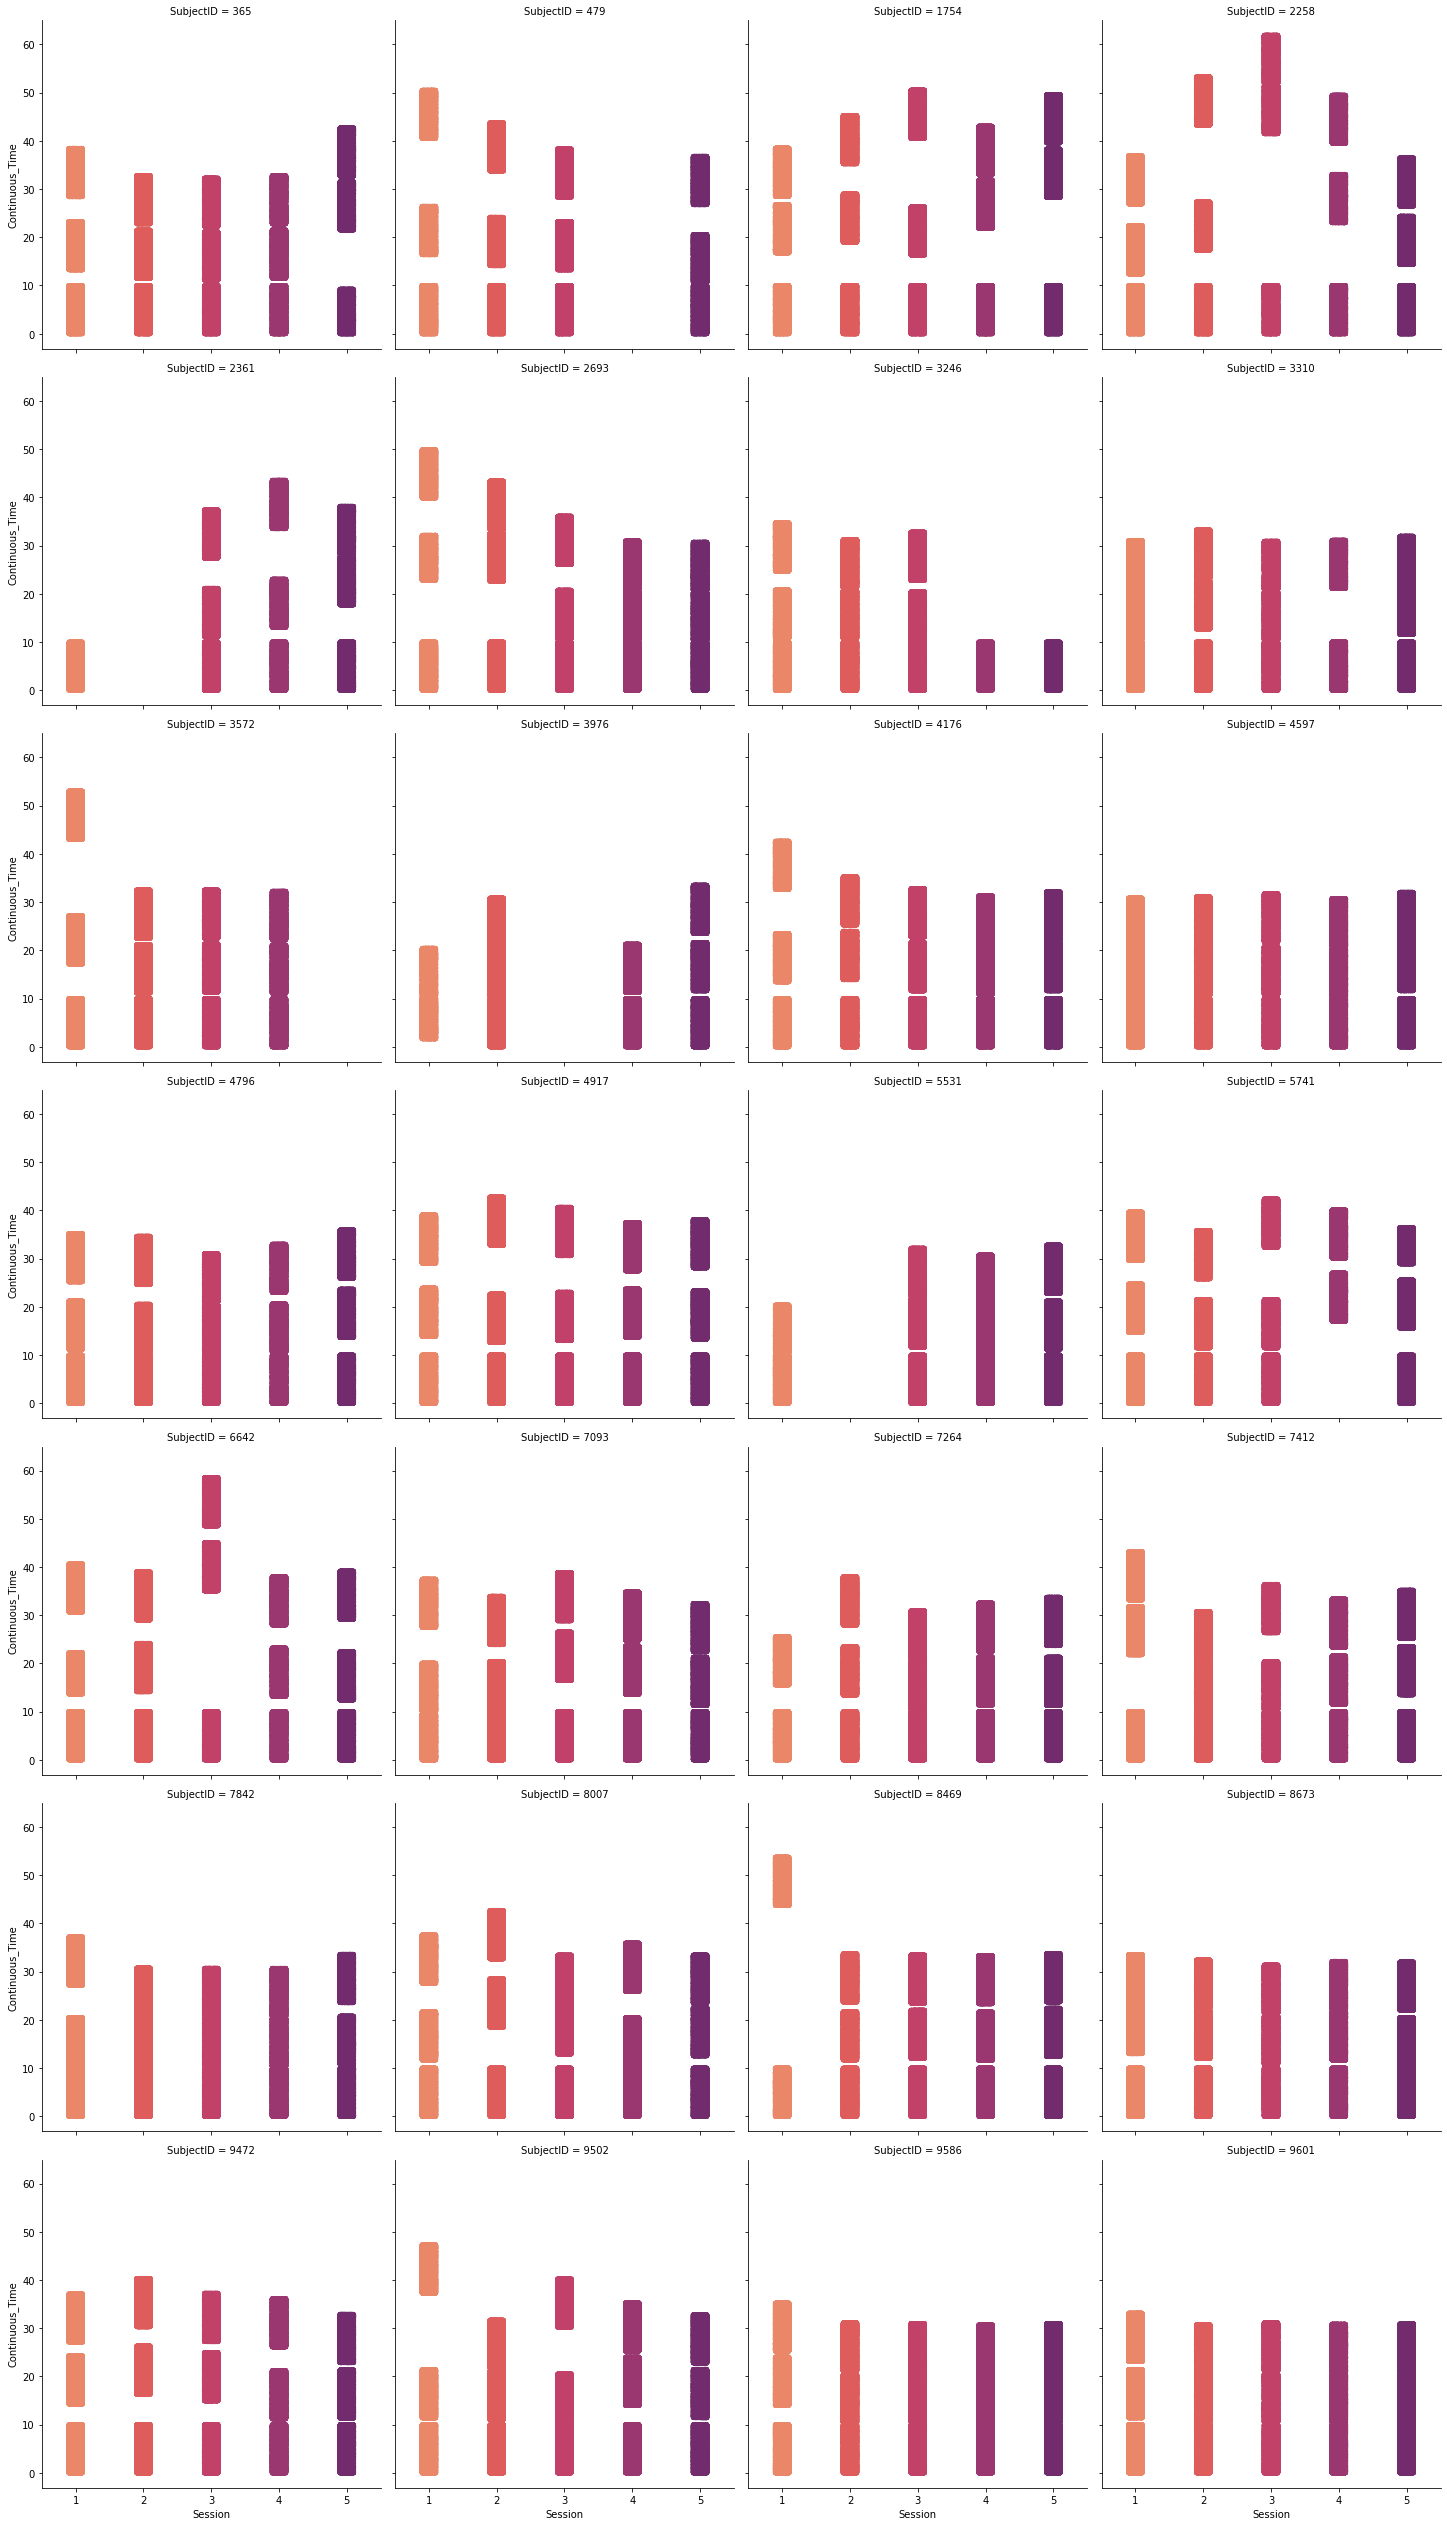

In [9]:
plot = data_frame[data_frame.Continuous_Time < 120]
sns.catplot(data=plot, col="SubjectID", y="Continuous_Time", x="Session",  col_wrap=4, palette="flare")

## Gaze processing

In [10]:
# Take  final row per fixation (the duration, average distance is the same all through the rows of the same fixation)
gaze = data_frame[data_frame.events == -2].copy()

### Get all gazes whose duration is more than 3.5 median standard deviations out 

In [11]:
gaze["Median_Standard_Duration"] = np.nanmedian(abs(gaze.length - np.nanmedian(gaze.length))) * 1.4826
gaze.loc[:, "gaze_mad_z"] = abs(gaze.length.tolist() - np.nanmedian(gaze.length)) / gaze.Median_Standard_Duration.tolist()
gaze.loc[:,"Outlier_Gaze_Length"] = np.where(gaze["gaze_mad_z"] > 3.5, "Out", "Stays")
gaze_no_out = gaze[gaze.Outlier_Gaze_Length != "Out"].copy()
gaze_no_out.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV_NO_Outliers.cvs")

In [12]:
gaze.Outlier_Gaze_Length.value_counts(normalize=True)

Stays    0.949539
Out      0.050461
Name: Outlier_Gaze_Length, dtype: float64

In [13]:
# See how many data points we're loosing by excluding outliers 
display(gaze.shape)
display(gaze_no_out.shape)

(760146, 52)

(721788, 52)

### Gaze Visualizations on complete data 

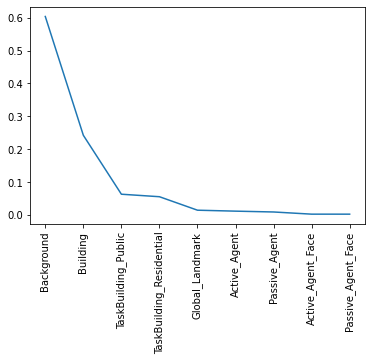

In [14]:
ax = gaze_no_out.Collider_CategoricalN.value_counts(normalize=True).plot()
ax.tick_params(axis='x', labelrotation = 90)

In [15]:
#General plotting settings
sns.set(rc={"figure.figsize":(20, 15)})
sns.set(font_scale = 1.3)
plt.tight_layout()

<Figure size 1440x1080 with 0 Axes>

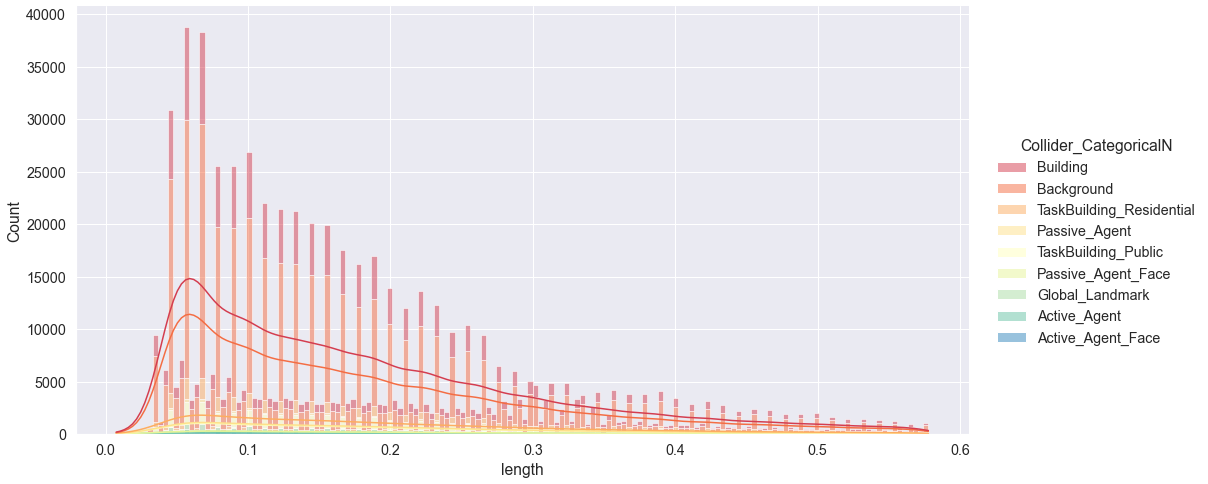

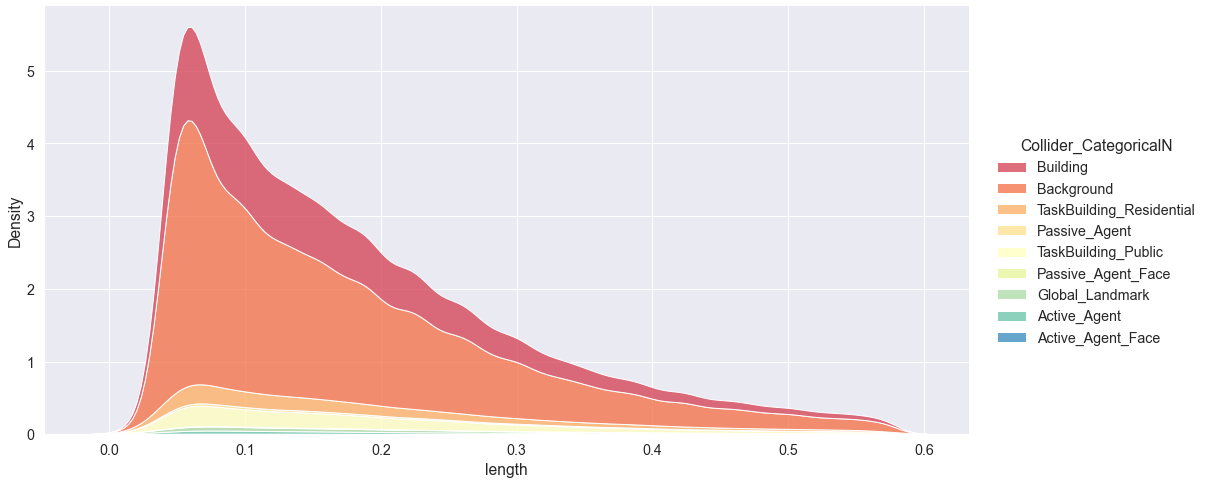

In [16]:
sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=7, aspect= 2, kde=True, palette="Spectral",  multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=gaze_no_out, 
            height=7, aspect= 2, kind="kde", palette="Spectral", multiple="stack")

In [17]:
# Since the collider names are too detailed, here we create a dictionary with patterns to classify them into our categories of interest
patterns = {'\d{2}_Sa':'Passive_Agent', '\d{2}_Cma':'Active_Agent', 'Building_\d+': 'Building'}
patterns.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))
patterns.update(dict.fromkeys(['^TaskBuilding_2$','^TaskBuilding_3$', '^TaskBuilding_5$', '^TaskBuilding_8$', '^TaskBuilding_9$', '^TaskBuilding_11$', '^TaskBuilding_13$', '^TaskBuilding_14$', '^TaskBuilding_20$', 
                               '^TaskBuilding_21$', '^TaskBuilding_23$','^TaskBuilding_27$', '^TaskBuilding_29$', '^TaskBuilding_32$', '^TaskBuilding_34$',  '^TaskBuilding_38$', '^TaskBuilding_41$', '^TaskBuilding_42$', 
                               '^TaskBuilding_44$', '^TaskBuilding_45$', '^TaskBuilding_47$', '^TaskBuilding_50$', '^TaskBuilding_51$', '^TaskBuilding_52$', 'BasketballCourt_58', 'Construction_57', 
                               '^Graffity_02$', '^Graffity_03$', '^Graffity_05$', '^Graffity_08$', '^Graffity_09$', '^Graffity_11$', '^Graffity_13$', '^Graffity_14$', '^Graffity_20$', 
                               '^Graffity_21$', '^Graffity_23$', '^Graffity_27$', '^Graffity_29$', '^Graffity_32$', '^Graffity_34$', '^Graffity_38$', '^Graffity_41$', '^Graffity_42$', 
                               '^Graffity_44$', '^Graffity_45$', '^Graffity_47$',  '^Graffity_50$', '^Graffity_51$', '^Graffity_52$'], 'TaskBuilding_Public'))

patterns.update(dict.fromkeys(['^TaskBuilding_1$','^TaskBuilding_4$', '^TaskBuilding_6$', '^TaskBuilding_7$', '^TaskBuilding_12$', '^TaskBuilding_15$', '^TaskBuilding_17$', '^TaskBuilding_18$', '^TaskBuilding_19$', 
                               '^TaskBuilding_22$', '^TaskBuilding_24$','^TaskBuilding_25$', '^TaskBuilding_26$', '^TaskBuilding_28$', '^TaskBuilding_30$',  '^TaskBuilding_31$', '^TaskBuilding_33$', '^TaskBuilding_35$', 
                               '^TaskBuilding_36$', '^TaskBuilding_37$', '^TaskBuilding_39$', '^TaskBuilding_40$', '^TaskBuilding_43$', '^TaskBuilding_48$', '^TaskBuilding_54$','^TaskBuilding_55$',
                               '^Graffity_01$','^Graffity_04$', '^Graffity_06$', '^Graffity_07$', '^Graffity_12$', '^Graffity_15$', '^Graffity_17$', '^Graffity_18$', '^Graffity_19$', '^Graffity_22$', 
                               '^Graffity_24$','^Graffity_25$', '^Graffity_26$', '^Graffity_28$', '^Graffity_30$',  '^Graffity_31$', '^Graffity_33$', '^Graffity_35$', '^Graffity_36$', '^Graffity_37$', '^Graffity_39$', 
                               '^Graffity_40$', '^Graffity_43$', '^Graffity_48$', '^Graffity_54$', '^Graffity_55$' ], 'TaskBuilding_Residential'))
default_val = 'Background'

In [18]:
gaze_no_out["Collider_CategoricalN"] =  gaze_no_out['names'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))
#string_to_add = "_Face"
# Define the condition and the string to add
#Mask_1f = ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Active_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face")) | ((data_frame_gaze_no_out_ONLY_TEST['Collider_CategoricalN'] == "Passive_Agent") & (data_frame_gaze_no_out_ONLY_TEST['Face_Hits'] == "Face"))
#data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] = data_frame_gaze_no_out_ONLY_TEST.loc[Mask_1f, 'Collider_CategoricalN'] + string_to_add

In [19]:
#Keep only the gazes that happened on the categories of interest
data_frame_gaze_no_out_ONLY_TEST = gaze_no_out[(gaze_no_out.Collider_CategoricalN != "Background") & (gaze_no_out.Collider_CategoricalN != "Building")].copy()

In [20]:
data_frame_gaze_no_out_ONLY_TEST.Collider_CategoricalN.value_counts(normalize=True)

TaskBuilding_Public         0.389936
TaskBuilding_Residential    0.371032
Global_Landmark             0.089991
Active_Agent                0.082838
Passive_Agent               0.066202
Name: Collider_CategoricalN, dtype: float64

In [21]:
data_frame_gaze_no_out_ONLY_TEST.head()

,Unnamed: 0,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,...,distance,avg_dist,names,Collider_CategoricalN,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Median_Standard_Duration,gaze_mad_z,Outlier_Gaze_Length
159,159,159,479,2,1,1.653045e+09,0,-59.116585,2.262560,34.702782,...,10.420032,10.422815,TaskBuilding_35,TaskBuilding_Residential,NaN,NaN,NaN,0.120601,0.185065,Stays
210,210,210,479,2,1,1.653045e+09,3,-59.121014,2.269164,34.681396,...,10.886178,10.879393,TaskBuilding_35,TaskBuilding_Residential,NaN,NaN,NaN,0.120601,0.555213,Stays
224,224,224,479,2,1,1.653045e+09,3,-59.145859,2.272603,34.664337,...,7.238938,7.239133,46_Sa,Passive_Agent,NaN,NaN,NaN,0.120601,0.279669,Stays
238,238,238,479,2,1,1.653045e+09,3,-59.124584,2.283468,34.640255,...,12.199331,12.183309,Graffity_35,TaskBuilding_Residential,NaN,NaN,NaN,0.120601,0.004096,Stays
253,253,253,479,2,1,1.653045e+09,3,-59.142059,2.288404,34.623589,...,12.443347,12.447341,Graffity_35,TaskBuilding_Residential,NaN,NaN,NaN,0.120601,0.551115,Stays


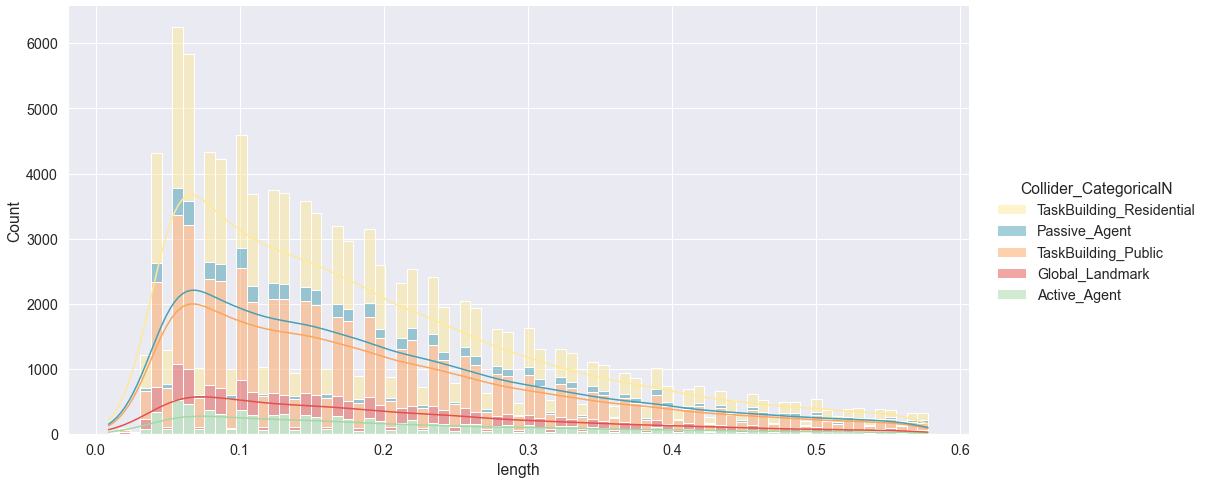

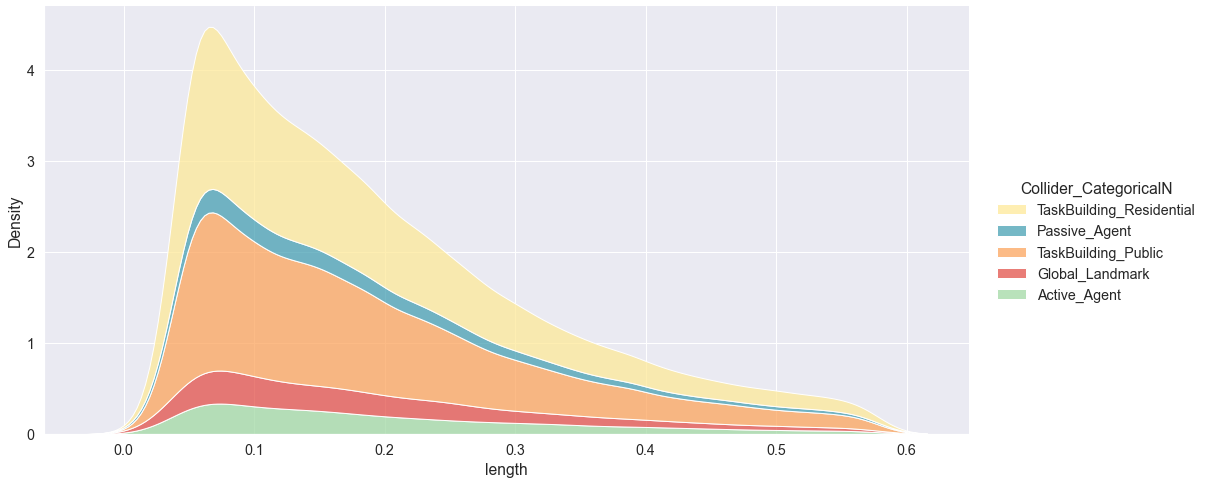

In [22]:
data = data_frame_gaze_no_out_ONLY_TEST.copy()
sns.displot(x='length', hue="Collider_CategoricalN",
             data=data, 
            height=7, aspect= 2, kde=True, palette=my_categories, multiple="stack")

sns.displot(x='length', hue="Collider_CategoricalN",
             data=data, 
            height=7, aspect= 2, kind="kde", palette=my_categories, multiple="stack")

In [24]:
data_frame_gaze_no_out_ONLY_TEST.Collider_CategoricalN.unique()

array(['TaskBuilding_Residential', 'Passive_Agent', 'TaskBuilding_Public',
       'Global_Landmark', 'Active_Agent'], dtype=object)

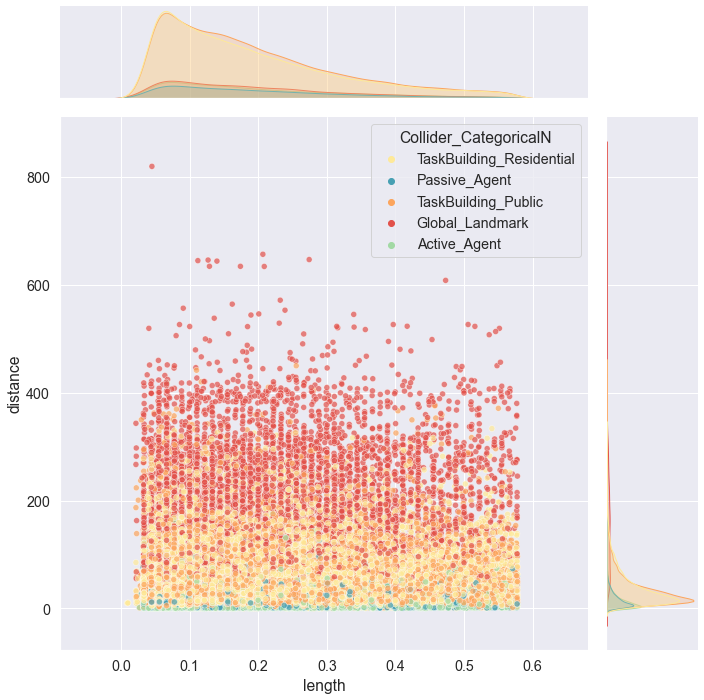

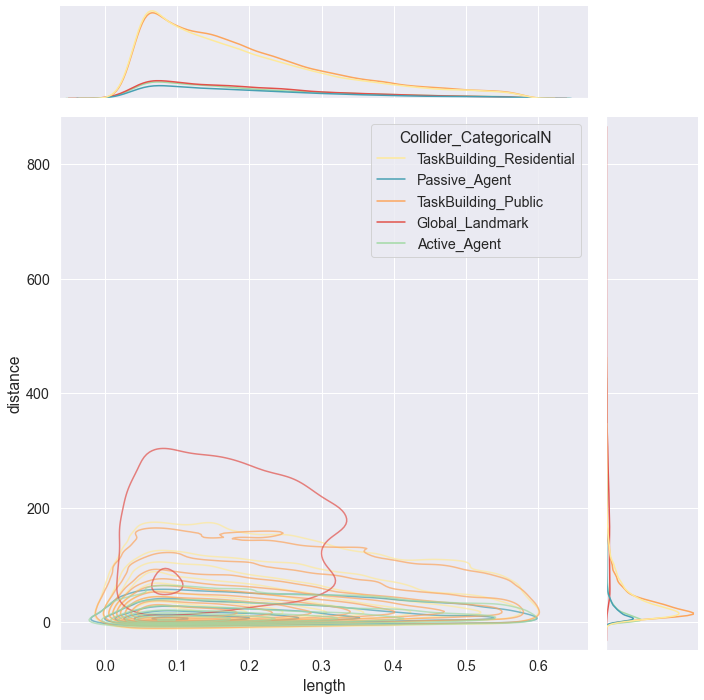

In [25]:
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=10, alpha=0.7, palette=my_categories)
sns.jointplot(data=data_frame_gaze_no_out_ONLY_TEST, y="distance", x="length", hue="Collider_CategoricalN",  height=10, alpha=0.7, palette=my_categories,  kind="kde")

In [26]:
# Create a Dictionary that identifies agent, graffity and house into this three categories
patterns2 = {'\d{2}_Sa':'Agent', '\d{2}_Cma':'Agent', '^TaskBuilding_': 'Building', 'BasketballCourt_58': 'Building', '^Graffity':'Graffity'}
patterns2.update(dict.fromkeys(['Castle-TaskBuilding_56', 'Crane_59','HighSilo-TaskBuilding_49', 'Windmill-TaskBuilding_10_1', 'Church-TaskBuilding_16'], 'Global_Landmark'))

In [27]:
data_frame_gaze_no_out_ONLY_TEST['Hit_Object_Category'] = data_frame_gaze_no_out_ONLY_TEST['names'].apply(lambda x: next((val for key, val in patterns2.items() if re.match(key, x)), default_val))    

In [28]:
data_frame_gaze_no_out_ONLY_TEST = data_frame_gaze_no_out_ONLY_TEST.loc[:, ~data_frame_gaze_no_out_ONLY_TEST.columns.str.contains('^Unnamed')]
data_frame_gaze_no_out_ONLY_TEST.head()

,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,eyeDirectionCombinedWorld.y,...,events,length,distance,avg_dist,names,Collider_CategoricalN,Median_Standard_Duration,gaze_mad_z,Outlier_Gaze_Length,Hit_Object_Category
159,159,479,2,1,1.653045e+09,0,-59.116585,2.262560,34.702782,-1.076677,...,-2.0,0.133425,10.420032,10.422815,TaskBuilding_35,TaskBuilding_Residential,0.120601,0.185065,Stays,Building
210,210,479,2,1,1.653045e+09,3,-59.121014,2.269164,34.681396,0.102463,...,-2.0,0.088784,10.886178,10.879393,TaskBuilding_35,TaskBuilding_Residential,0.120601,0.555213,Stays,Building
224,224,479,2,1,1.653045e+09,3,-59.145859,2.272603,34.664337,-0.013656,...,-2.0,0.122015,7.238938,7.239133,46_Sa,Passive_Agent,0.120601,0.279669,Stays,Agent
238,238,479,2,1,1.653045e+09,3,-59.124584,2.283468,34.640255,0.221266,...,-2.0,0.155250,12.199331,12.183309,Graffity_35,TaskBuilding_Residential,0.120601,0.004096,Stays,Graffity
253,253,479,2,1,1.653045e+09,3,-59.142059,2.288404,34.623589,0.298437,...,-2.0,0.222209,12.443347,12.447341,Graffity_35,TaskBuilding_Residential,0.120601,0.551115,Stays,Graffity


### Recode to count the graffity as the house hit 

In [29]:
# Map graffity into the name of the building that it's in front of 
Graffity_mapping = {'Graffity_14':'TaskBuilding_14', 
                  'Graffity_41': 'TaskBuilding_41',
                  'Graffity_02': 'TaskBuilding_2', 
                  'Graffity_47': 'TaskBuilding_47',
                  'Graffity_20': 'TaskBuilding_20',
                  'Graffity_09': 'TaskBuilding_9',
                  'Graffity_50': 'TaskBuilding_50',
                  'Graffity_45': 'TaskBuilding_45',
                  'Graffity_08': 'TaskBuilding_8',
                  'Graffity_27': 'TaskBuilding_27',
                  'Graffity_51': 'TaskBuilding_51',
                  'Graffity_03': 'TaskBuilding_3',
                  'Graffity_11': 'TaskBuilding_11',
                  'Graffity_42': 'TaskBuilding_42',
                  'Graffity_23': 'TaskBuilding_23',
                  'Graffity_52': 'TaskBuilding_52',
                  'Graffity_38': 'TaskBuilding_38',
                  'Graffity_34': 'TaskBuilding_34',
                  'Graffity_05': 'TaskBuilding_5',
                  'Graffity_29': 'TaskBuilding_29',
                  'Graffity_32': 'TaskBuilding_32',
                  'Graffity_13': 'TaskBuilding_13',
                  'Graffity_44': 'TaskBuilding_44',
                  'Graffity_21': 'TaskBuilding_21',
                  'Graffity_04': 'TaskBuilding_4',
                  'Graffity_01': 'TaskBuilding_1',
                  'Graffity_06': 'TaskBuilding_6',
                  'Graffity_07': 'TaskBuilding_7',  
                  'Graffity_17': 'TaskBuilding_17', 
                  'Graffity_15': 'TaskBuilding_15',
                  'Graffity_12': 'TaskBuilding_12',
                  'Graffity_18': 'TaskBuilding_18',
                  'Graffity_19': 'TaskBuilding_19',
                  'Graffity_22': 'TaskBuilding_22',
                  'Graffity_24': 'TaskBuilding_24',
                  'Graffity_25': 'TaskBuilding_25',
                  'Graffity_26': 'TaskBuilding_26',
                  'Graffity_28': 'TaskBuilding_28',
                  'Graffity_30': 'TaskBuilding_30',
                  'Graffity_31': 'TaskBuilding_31',
                  'Graffity_33': 'TaskBuilding_33',
                  'Graffity_35': 'TaskBuilding_35',
                  'Graffity_36': 'TaskBuilding_36',
                  'Graffity_37': 'TaskBuilding_37',
                  'Graffity_39': 'TaskBuilding_39',
                  'Graffity_40': 'TaskBuilding_40',
                  'Graffity_43': 'TaskBuilding_43',
                  'Graffity_48': 'TaskBuilding_48',
                  'Graffity_54': 'TaskBuilding_54',
                  'Graffity_55': 'TaskBuilding_55'
             }

In [30]:
data_frame_gaze_no_out_ONLY_TEST.loc[:, 'recoded'] = data_frame_gaze_no_out_ONLY_TEST.loc[:,'names']
data_frame_gaze_no_out_ONLY_TEST['recoded'].replace(Graffity_mapping, inplace=True)

In [31]:
data_frame_gaze_no_out_ONLY_TEST["Collider_CategoricalN"] =  data_frame_gaze_no_out_ONLY_TEST['recoded'].apply(lambda x: next((val for key, val in patterns.items() if re.match(key, x)), default_val))

## Cummulative sum calculation

In [32]:
data_frame_gaze_no_out_ONLY_TEST["cumsum_length"] = data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "recoded", "Collider_CategoricalN"])['length'].cumsum()

In [33]:
data_frame_gaze_no_out_ONLY_TEST.head(20)

,index,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,combinedGazeValidityBitmask,eyePositionCombinedWorld.x,eyePositionCombinedWorld.y,eyePositionCombinedWorld.z,eyeDirectionCombinedWorld.y,...,distance,avg_dist,names,Collider_CategoricalN,Median_Standard_Duration,gaze_mad_z,Outlier_Gaze_Length,Hit_Object_Category,recoded,cumsum_length
159,159,479,2,1,1.653045e+09,0,-59.116585,2.262560,34.702782,-1.076677,...,10.420032,10.422815,TaskBuilding_35,TaskBuilding_Residential,0.120601,0.185065,Stays,Building,TaskBuilding_35,0.133425
210,210,479,2,1,1.653045e+09,3,-59.121014,2.269164,34.681396,0.102463,...,10.886178,10.879393,TaskBuilding_35,TaskBuilding_Residential,0.120601,0.555213,Stays,Building,TaskBuilding_35,0.222209
224,224,479,2,1,1.653045e+09,3,-59.145859,2.272603,34.664337,-0.013656,...,7.238938,7.239133,46_Sa,Passive_Agent,0.120601,0.279669,Stays,Agent,46_Sa,0.122015
238,238,479,2,1,1.653045e+09,3,-59.124584,2.283468,34.640255,0.221266,...,12.199331,12.183309,Graffity_35,TaskBuilding_Residential,0.120601,0.004096,Stays,Graffity,TaskBuilding_35,0.377459
253,253,479,2,1,1.653045e+09,3,-59.142059,2.288404,34.623589,0.298437,...,12.443347,12.447341,Graffity_35,TaskBuilding_Residential,0.120601,0.551115,Stays,Graffity,TaskBuilding_35,0.599668
265,265,479,2,1,1.653045e+09,3,-59.122555,2.289922,34.626995,0.373928,...,12.669049,12.663635,Graffity_35,TaskBuilding_Residential,0.120601,0.464744,Stays,Graffity,TaskBuilding_35,0.699363
278,278,479,2,1,1.653045e+09,3,-59.119770,2.290059,34.638863,0.365780,...,12.813781,12.807124,Graffity_35,TaskBuilding_Residential,0.120601,0.271435,Stays,Graffity,TaskBuilding_35,0.887842
308,308,479,2,1,1.653045e+09,3,-59.136436,2.281899,34.655319,0.001372,...,7.324215,7.327927,46_Sa,Passive_Agent,0.120601,1.196808,Stays,Agent,46_Sa,0.422096
317,317,479,2,1,1.653045e+09,3,-59.143734,2.276149,34.657501,-0.041063,...,7.306871,7.311146,46_Sa,Passive_Agent,0.120601,0.555217,Stays,Agent,46_Sa,0.510880
327,327,479,2,1,1.653045e+09,3,-59.180134,2.267978,34.665527,-0.017279,...,7.208899,7.217242,46_Sa,Passive_Agent,0.120601,0.559327,Stays,Agent,46_Sa,0.599168


In [34]:
data_frame_gaze_no_out_ONLY_TEST[["length", "recoded", "cumsum_length"]] 

,length,recoded,cumsum_length
159,0.133425,TaskBuilding_35,0.133425
210,0.088784,TaskBuilding_35,0.222209
224,0.122015,46_Sa,0.122015
238,0.155250,TaskBuilding_35,0.377459
253,0.222209,TaskBuilding_35,0.599668
...,...,...,...
15815341,0.206335,TaskBuilding_25,16.181260
15815377,0.241054,TaskBuilding_25,16.422314
15819614,0.336781,BasketballCourt_58,9.761820
15819952,0.182526,TaskBuilding_28,2.538527


In [35]:
data_frame_gaze_no_out_ONLY_TEST.cumsum_length.describe()

count    111144.000000
mean          8.008096
std           8.089191
min           0.010912
25%           2.343595
50%           5.654398
75%          10.984282
max          83.283593
Name: cumsum_length, dtype: float64

In [36]:
Dwelling_time = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].max())
Dwelling_time.reset_index(inplace=True)
Count = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID","recoded","Collider_CategoricalN"])["cumsum_length"].count())
Count.reset_index(inplace=True)
Fixations = Dwelling_time.merge(Count, on=["SubjectID", "recoded","Collider_CategoricalN"])
Fixations.rename({"cumsum_length_x": "Dwelling_Time", "cumsum_length_y":"Fixation_Count"}, axis=1, inplace=True)

In [37]:
Fixations

,SubjectID,recoded,Collider_CategoricalN,Dwelling_Time,Fixation_Count
0,365,01_Cma,Active_Agent,0.999441,5
1,365,02_Cma,Active_Agent,2.241917,8
2,365,05_Cma,Active_Agent,0.255441,2
3,365,06_Cma,Active_Agent,4.235831,19
4,365,07_Cma,Active_Agent,1.380368,6
...,...,...,...,...,...
2947,9601,TaskBuilding_6,TaskBuilding_Residential,19.694432,93
2948,9601,TaskBuilding_7,TaskBuilding_Residential,5.850799,31
2949,9601,TaskBuilding_8,TaskBuilding_Public,9.518699,44
2950,9601,TaskBuilding_9,TaskBuilding_Public,8.078908,44


In [38]:
Fixations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2952 entries, 0 to 2951
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SubjectID              2952 non-null   int64  
 1   recoded                2952 non-null   object 
 2   Collider_CategoricalN  2952 non-null   object 
 3   Dwelling_Time          2952 non-null   float64
 4   Fixation_Count         2952 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 138.4+ KB


## Make sure that the cummulative sum equals the same as the raw length 

In [39]:
Fixation_sum = pd.DataFrame(Fixations.groupby(["SubjectID"])["Dwelling_Time"].sum())
Fixation_sum.reset_index(inplace=True)
Fixation_sum.loc[:, "Minutes"] = (Fixation_sum.Dwelling_Time)/60
Fixation_sum.loc[:, "Hours"] = (Fixation_sum.Minutes)/60
Fixation_sum

,SubjectID,Dwelling_Time,Minutes,Hours
0,365,670.195660,11.169928,0.186165
1,479,912.467327,15.207789,0.253463
2,1754,1058.807697,17.646795,0.294113
3,2258,1025.001573,17.083360,0.284723
4,2361,853.782435,14.229707,0.237162
5,2693,945.511819,15.758530,0.262642
6,3246,641.597449,10.693291,0.178222
7,3310,753.454066,12.557568,0.209293
8,3572,802.816193,13.380270,0.223004
9,3976,605.621105,10.093685,0.168228


In [99]:
Fixation_sum[Fixation_sum.SubjectID == 5238]

,SubjectID,Dwelling_Time,Minutes,Hours


In [40]:
Complete_Sum = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID"])["length"].sum())
Complete_Sum.reset_index(inplace=True)
Complete_Sum.loc[:, "Minutes"] = (Complete_Sum.length)/60
Complete_Sum.loc[:, "Hours"] = (Complete_Sum.Minutes)/60
Complete_Sum

,SubjectID,length,Minutes,Hours
0,365,670.195660,11.169928,0.186165
1,479,912.467327,15.207789,0.253463
2,1754,1058.807697,17.646795,0.294113
3,2258,1025.001573,17.083360,0.284723
4,2361,853.782435,14.229707,0.237162
5,2693,945.511819,15.758530,0.262642
6,3246,641.597449,10.693291,0.178222
7,3310,753.454066,12.557568,0.209293
8,3572,802.816193,13.380270,0.223004
9,3976,605.621105,10.093685,0.168228


In [41]:
TaskBuildings_GL = Fixations.loc[(Fixations.recoded.str.match('^TaskBuilding_')) | (Fixations.Collider_CategoricalN == 'Global_Landmark') ]
order_buildings = pd.DataFrame(TaskBuildings_GL.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))
Agents = Fixations.loc[Fixations.Collider_CategoricalN.str.contains("Agent")]
order_agents = pd.DataFrame(Agents.groupby("recoded")["Dwelling_Time"].median().sort_values(ascending=False))

In [42]:
Agents

,SubjectID,recoded,Collider_CategoricalN,Dwelling_Time,Fixation_Count
0,365,01_Cma,Active_Agent,0.999441,5
1,365,02_Cma,Active_Agent,2.241917,8
2,365,05_Cma,Active_Agent,0.255441,2
3,365,06_Cma,Active_Agent,4.235831,19
4,365,07_Cma,Active_Agent,1.380368,6
...,...,...,...,...,...
2891,9601,51_Sa,Passive_Agent,6.200965,27
2892,9601,52_Sa,Passive_Agent,1.078302,5
2893,9601,53_Sa,Passive_Agent,0.376387,2
2894,9601,54_Sa,Passive_Agent,0.388366,2


### Visualization of Dweling-Times (AKA. cummulative sums) 

In [43]:
Fixations[['Dwelling_Time', 'Fixation_Count']].corr().style.background_gradient(cmap="Spectral")

,Dwelling_Time,Fixation_Count
Dwelling_Time,1.000000,0.987477
Fixation_Count,0.987477,1.000000


In [44]:
Fixation_count = pd.DataFrame(Fixations.groupby("Collider_CategoricalN")["Fixation_Count"].mean().sort_values(ascending=False))
Fixation_count

,Fixation_Count
Collider_CategoricalN,
Global_Landmark,89.303571
TaskBuilding_Public,59.943292
TaskBuilding_Residential,56.723521
Active_Agent,13.004237
Passive_Agent,10.788856


In [45]:
pal = sns.color_palette("Spectral")
display(pal.as_hex()[:])
Fixations.Collider_CategoricalN.unique()

['#e2514a', '#fca55d', '#fee999', '#edf8a3', '#a2d9a4', '#47a0b3']

array(['Active_Agent', 'Passive_Agent', 'TaskBuilding_Public',
       'Global_Landmark', 'TaskBuilding_Residential'], dtype=object)

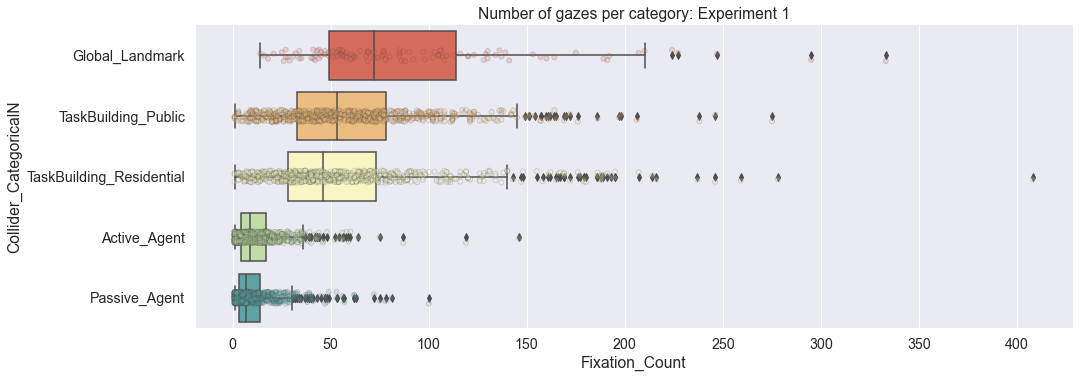

In [46]:
sns.catplot(y="Collider_CategoricalN", x="Fixation_Count", order= Fixation_count.index.values, data=Fixations, \
            height=5, aspect=3, kind='box', palette="Spectral").set(title="Number of gazes per category: Experiment 1")
ax = sns.stripplot(y="Collider_CategoricalN", x="Fixation_Count",  order= Fixation_count.index.values, data=Fixations, \
                   alpha=0.2, dodge=True,linewidth=1,edgecolor='gray', palette="Spectral")


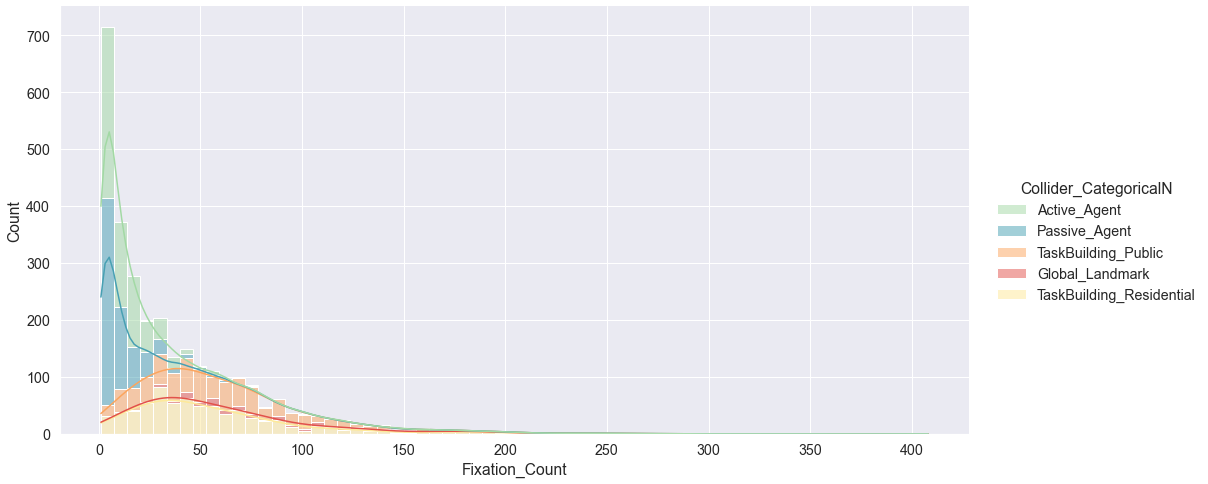

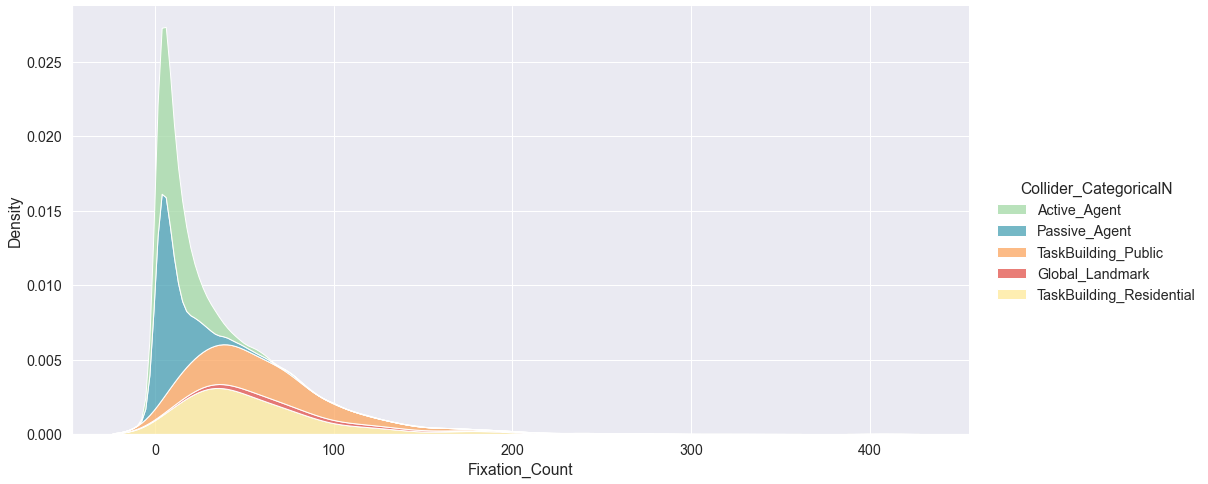

In [47]:
sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kde=True, palette=my_categories, multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kind="kde", palette=my_categories, multiple="stack")

In [48]:
Fixation_Dwelling_Time = pd.DataFrame(Fixations.groupby("Collider_CategoricalN")["Dwelling_Time"].mean().sort_values(ascending=False))
Fixation_Dwelling_Time

,Dwelling_Time
Collider_CategoricalN,
Global_Landmark,17.861976
TaskBuilding_Public,11.680913
TaskBuilding_Residential,10.799681
Active_Agent,2.672252
Passive_Agent,2.227274


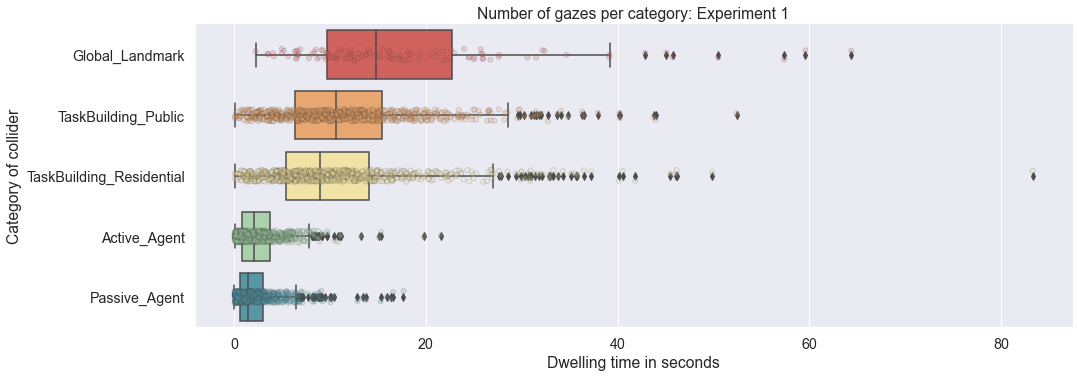

In [49]:
sns.catplot(y="Collider_CategoricalN", x="Dwelling_Time", order= Fixation_Dwelling_Time.index.values, data=Fixations, \
            height=5, aspect=3, kind='box', palette=my_categories)
ax = sns.stripplot(y="Collider_CategoricalN", x="Dwelling_Time",  order= Fixation_Dwelling_Time.index.values, data=Fixations, \
                   alpha=0.2, dodge=True,linewidth=1,edgecolor='gray', palette=my_categories).set(title="Number of gazes per category: Experiment 1", xlabel="Dwelling time in seconds", ylabel= "Category of collider")

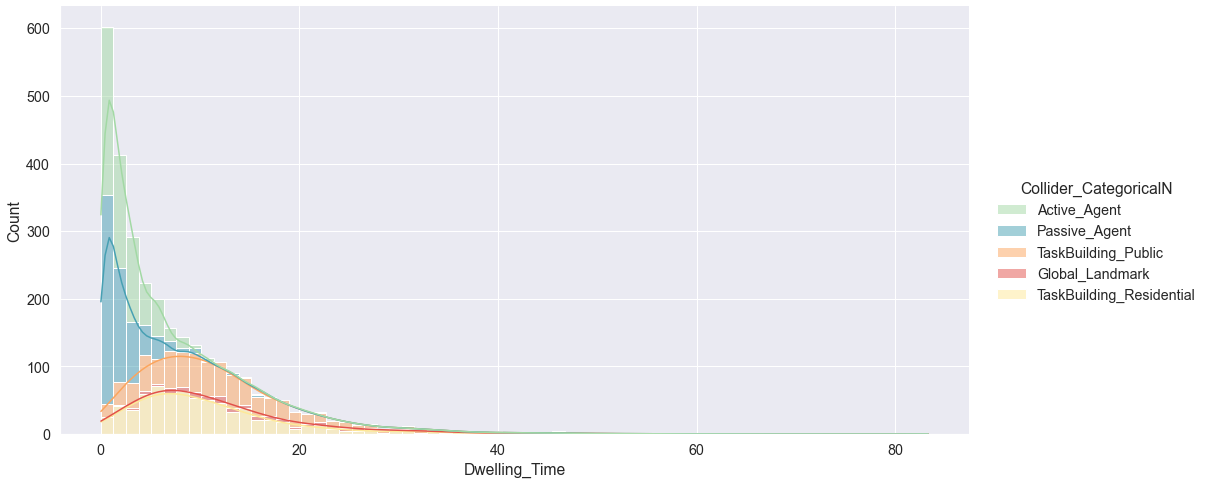

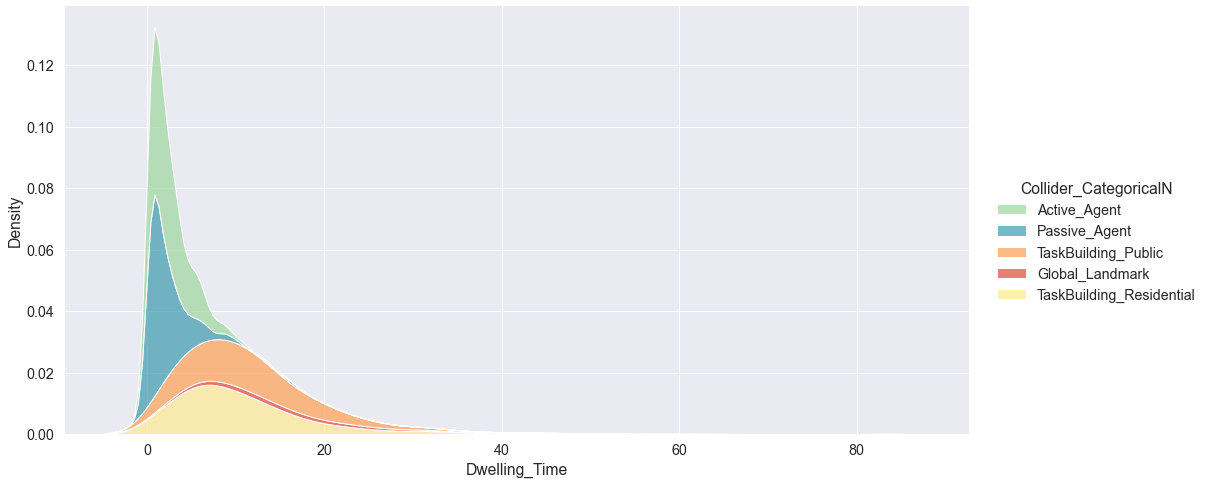

In [50]:
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kde=True, palette=my_categories, multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kind="kde", palette=my_categories, multiple="stack")

<AxesSubplot: xlabel='Fixation_Count', ylabel='Dwelling_Time'>

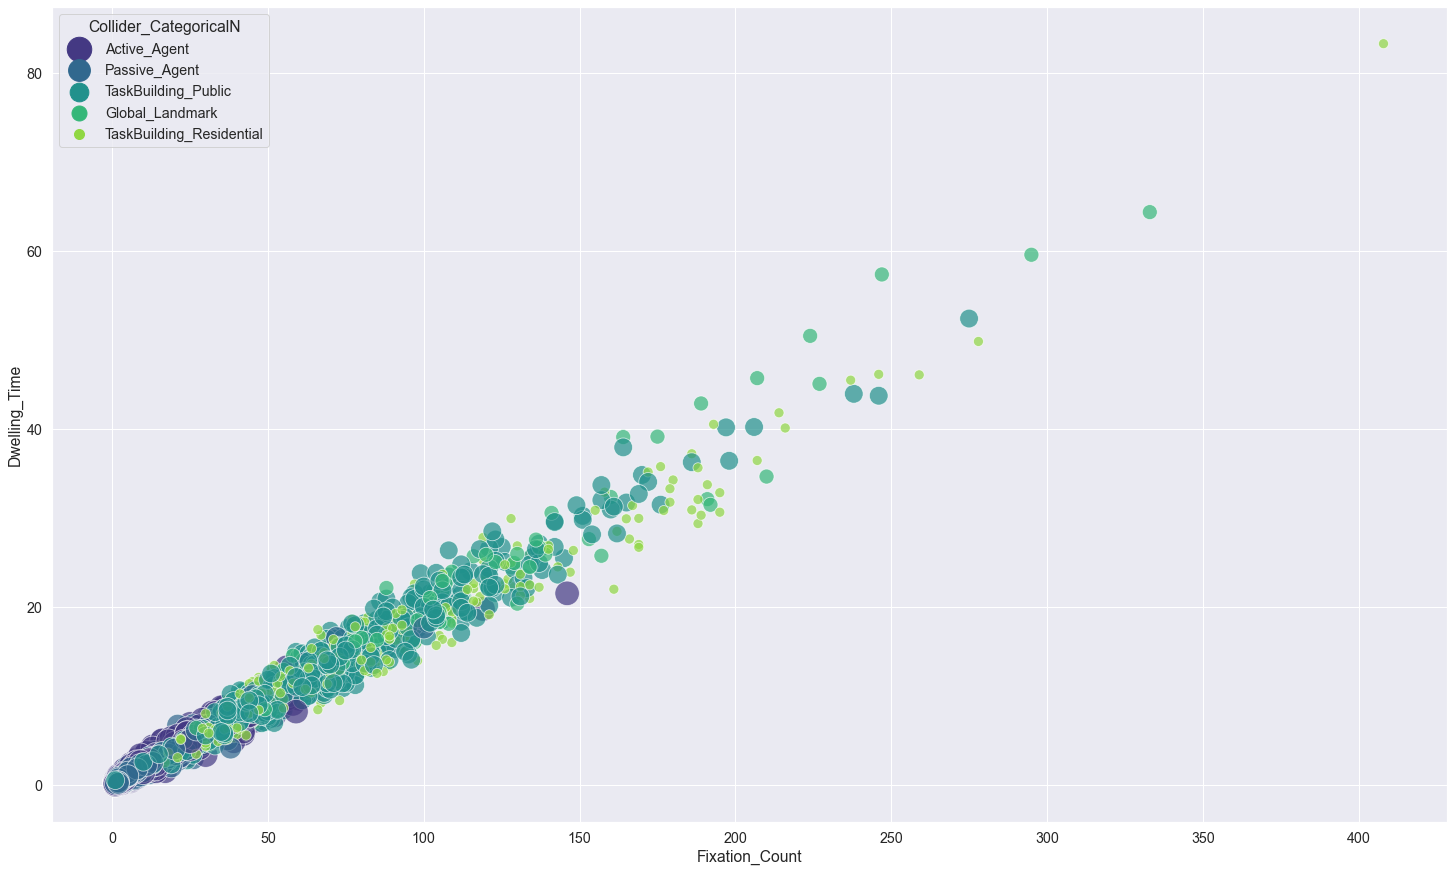

In [51]:
plt.figure(figsize=(25,15))
sns.set(font_scale = 1.3)
sns.scatterplot(x='Fixation_Count', y='Dwelling_Time', hue="Collider_CategoricalN",
                size="Collider_CategoricalN", sizes=(100,600), legend="full", data=Fixations, alpha=0.7, palette="viridis")

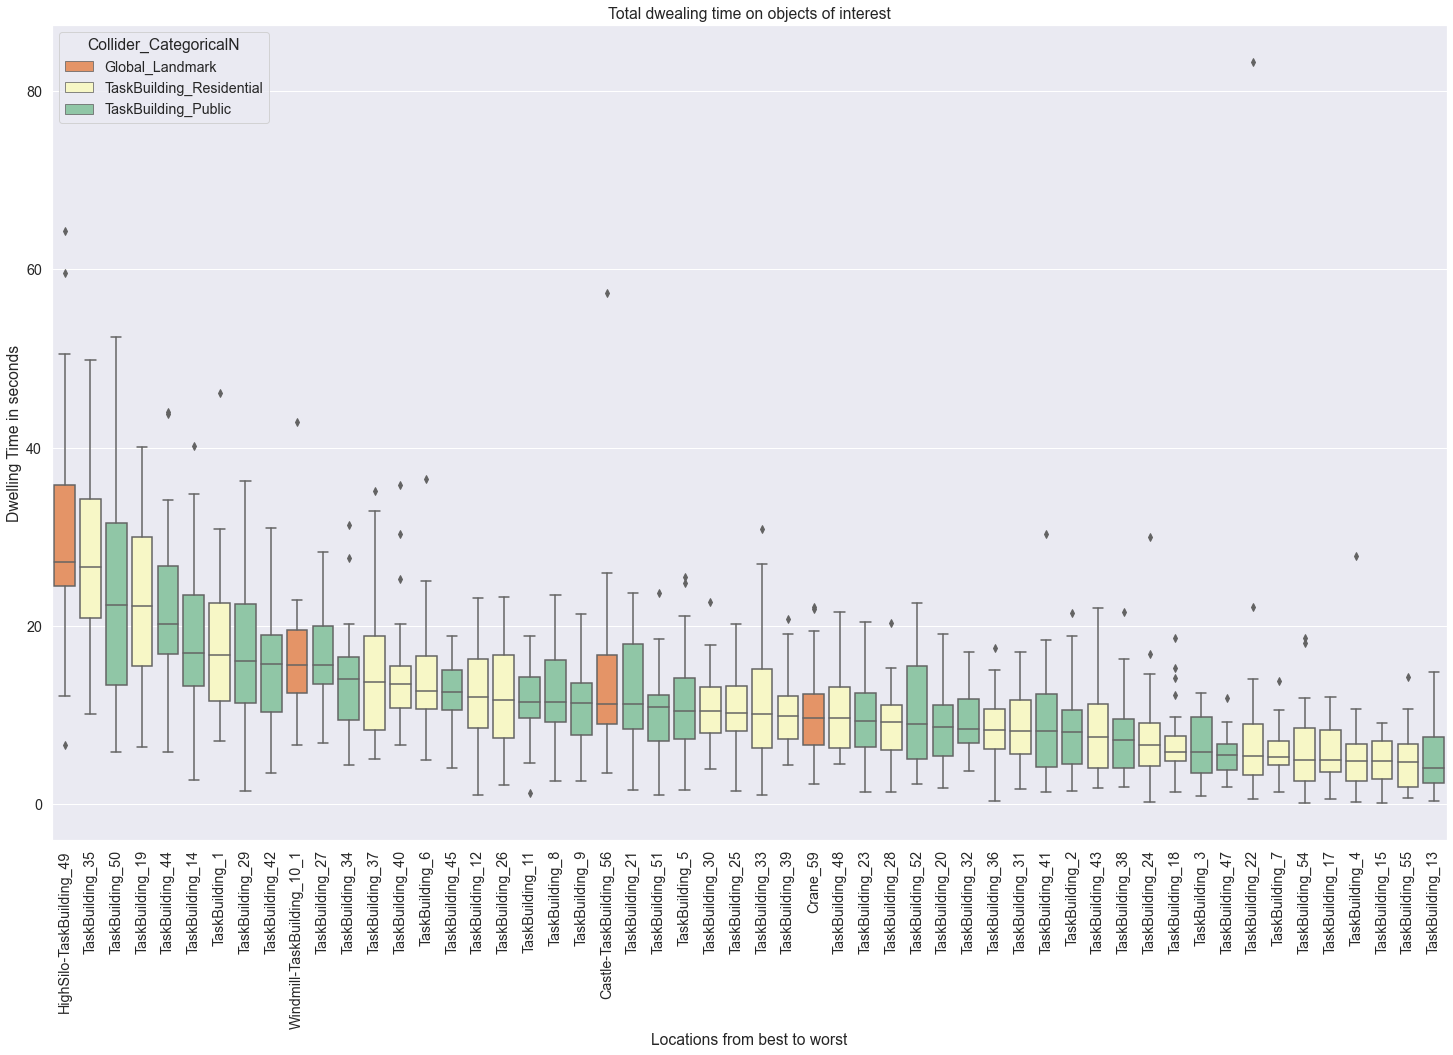

In [52]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="Spectral")
plt.title('Total dwealing time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

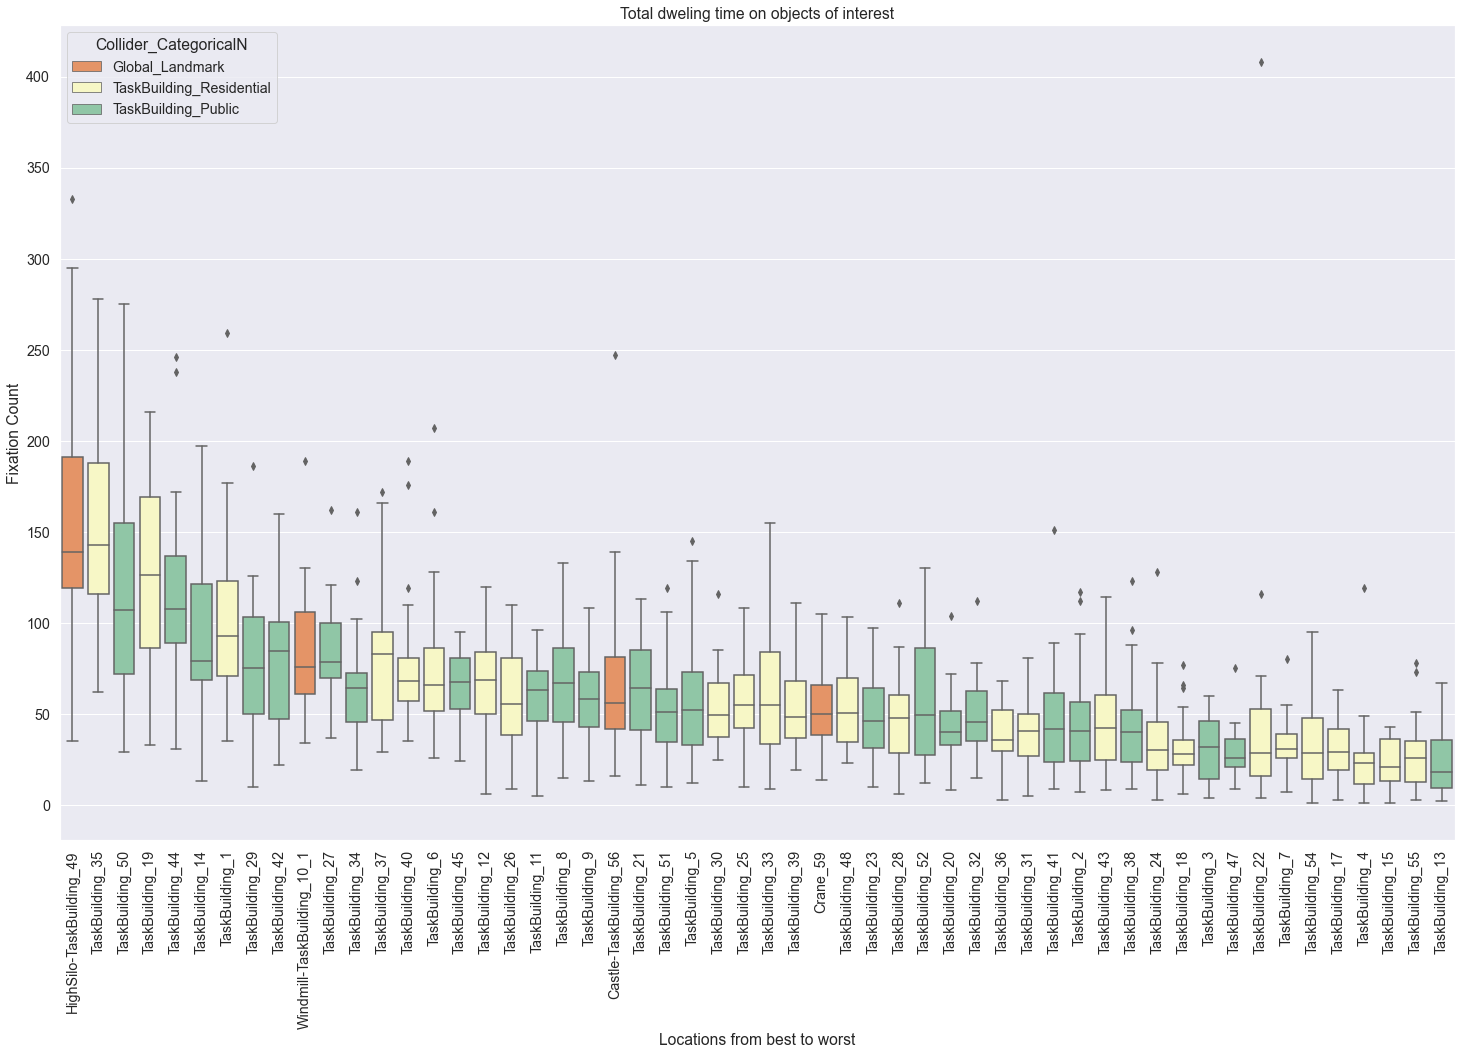

In [53]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_buildings.index.values, data=TaskBuildings_GL, palette="Spectral")
plt.title('Total dweling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

In [54]:
my_categories_agent = {'Active_Agent': '#a2d9a4',
                'Passive_Agent': '#47a0b3'}

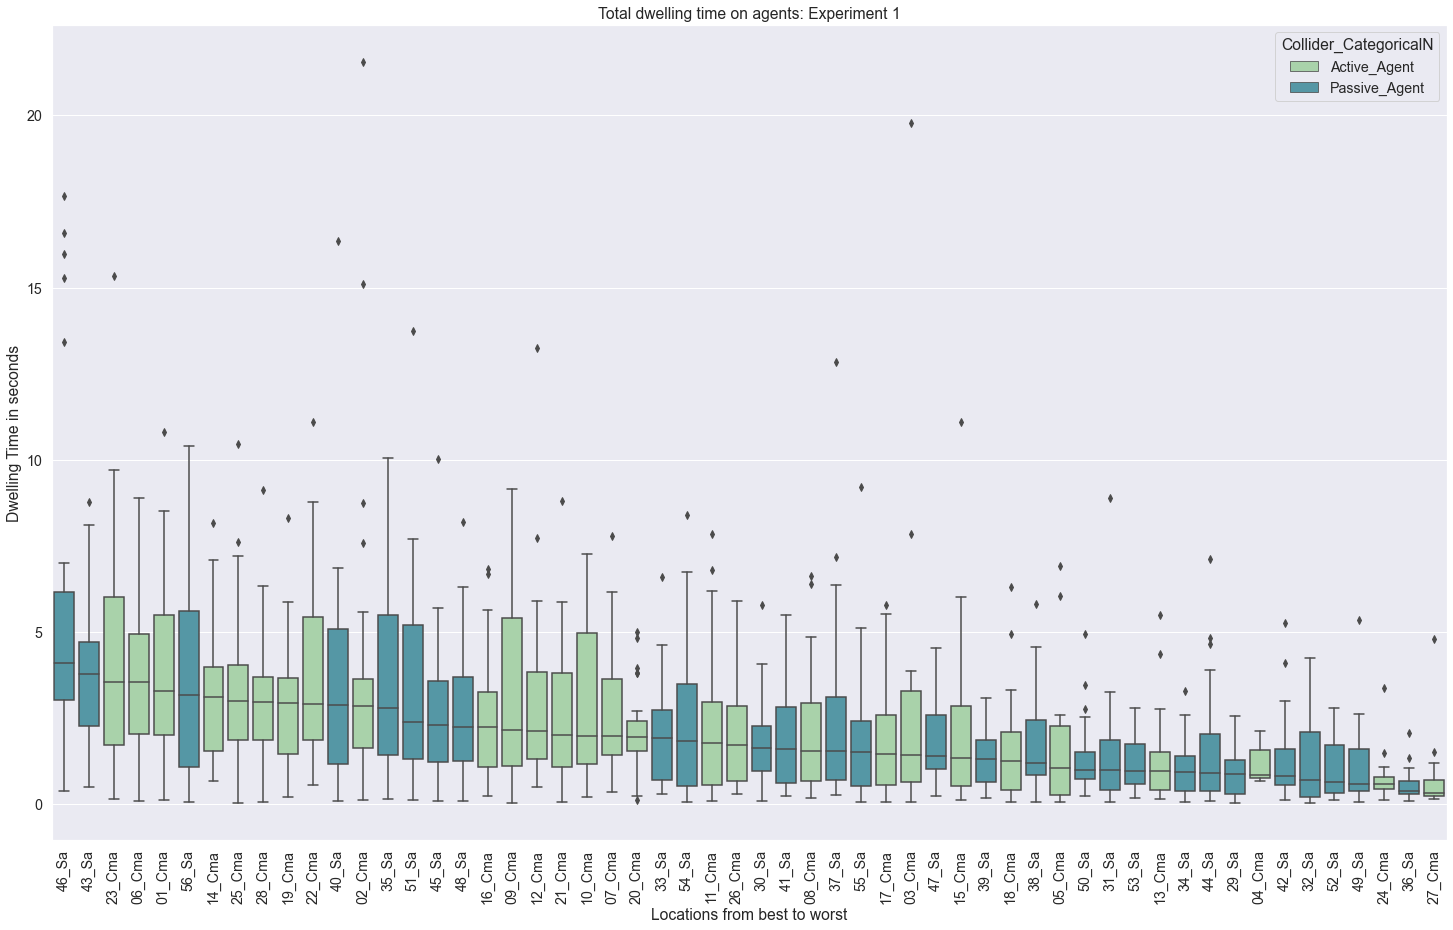

In [55]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Dwelling_Time', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette=my_categories_agent)
plt.title('Total dwelling time on agents: Experiment 1')
plt.xlabel('Locations from best to worst')
plt.ylabel('Dwelling Time in seconds')
plt.xticks(rotation=90);

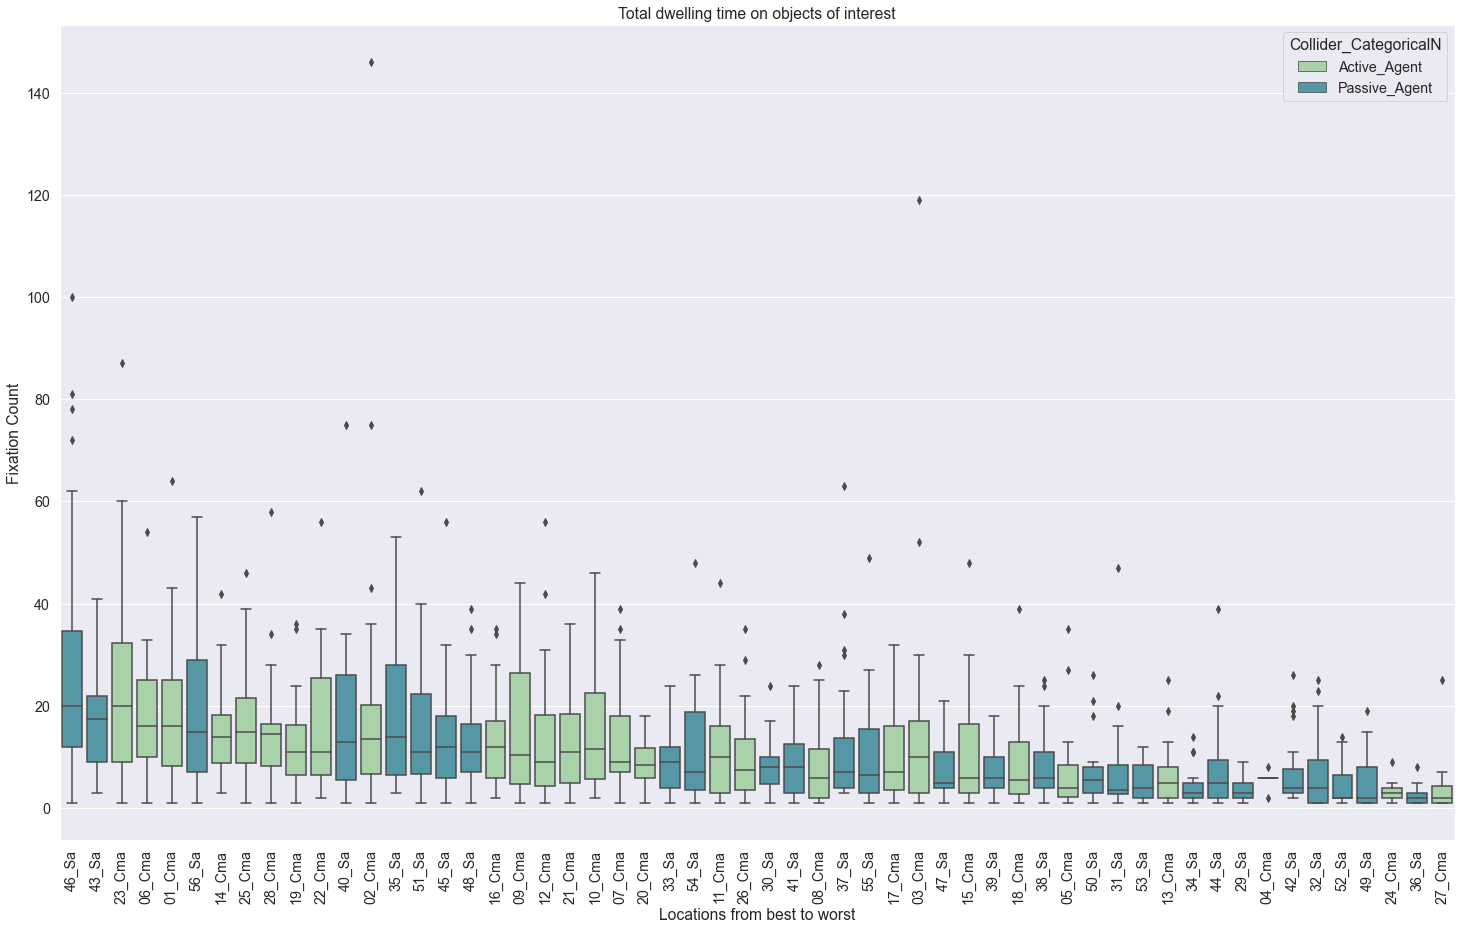

In [56]:
plt.figure(figsize=(25,15))
a = sns.boxplot(x='recoded', y='Fixation_Count', dodge=False, hue="Collider_CategoricalN", order= order_agents.index.values, data=Agents, palette=my_categories_agent )
plt.title('Total dwelling time on objects of interest')
plt.xlabel('Locations from best to worst')
plt.ylabel('Fixation Count')
plt.xticks(rotation=90);

## Preparation for the merging of behavioral data with Dwelling times 

In [57]:
# Create a dictionary that identifies: Agent, Building, and graffity with one ID
patterns1 = {'^01_Cma$':1}
patterns1.update(dict.fromkeys(['^TaskBuilding_14$','^Graffity_14$'], 1))
patterns1.update(dict.fromkeys(['^02_Cma$','^TaskBuilding_41$','^Graffity_41$'], 2))
patterns1.update(dict.fromkeys(['^03_Cma$','^TaskBuilding_2$', '^Graffity_02$'], 3))
patterns1.update(dict.fromkeys(['^04_Cma$','^TaskBuilding_47$','^Graffity_47$'], 4))
patterns1.update(dict.fromkeys(['^05_Cma$','^Construction_57$'], 5))
patterns1.update(dict.fromkeys(['^06_Cma$','^TaskBuilding_20$','^Graffity_20$'], 6))
patterns1.update(dict.fromkeys(['^07_Cma$','^TaskBuilding_9$','^Graffity_09$'], 7))
patterns1.update(dict.fromkeys(['^08_Cma$','^TaskBuilding_50$','^Graffity_50$'], 8))
patterns1.update(dict.fromkeys(['^09_Cma$','^TaskBuilding_45$','^Graffity_45$'], 9))
patterns1.update(dict.fromkeys(['^10_Cma$','^TaskBuilding_8$','^Graffity_08$'], 10))
patterns1.update(dict.fromkeys(['^11_Cma$','^TaskBuilding_27$','^Graffity_27$'], 11))
patterns1.update(dict.fromkeys(['^12_Cma$','^TaskBuilding_51$','^Graffity_51$'], 12))
patterns1.update(dict.fromkeys(['^13_Cma$','^TaskBuilding_3$','^Graffity_03$'], 13))
patterns1.update(dict.fromkeys(['^14_Cma$','^TaskBuilding_11$','^Graffity_11$'], 14))
patterns1.update(dict.fromkeys(['^15_Cma$','^TaskBuilding_42$','^Graffity_42$'], 15))
patterns1.update(dict.fromkeys(['^16_Cma$','^TaskBuilding_23$','^Graffity_23$'], 16))
patterns1.update(dict.fromkeys(['^17_Cma$','^TaskBuilding_52$','^Graffity_52$'], 17))
patterns1.update(dict.fromkeys(['^18_Cma$','^TaskBuilding_38$','^Graffity_38$'], 18))
patterns1.update(dict.fromkeys(['^19_Cma$','^TaskBuilding_34$','^Graffity_34$'], 19))
patterns1.update(dict.fromkeys(['^20_Cma$','^BasketballCourt_58$'], 20))
patterns1.update(dict.fromkeys(['^21_Cma$','^TaskBuilding_5$','^Graffity_05$'], 21))
patterns1.update(dict.fromkeys(['^22_Cma$','^TaskBuilding_29$','^Graffity_29$'], 22))
patterns1.update(dict.fromkeys(['^23_Cma$','^TaskBuilding_32$','^Graffity_32$'], 23))
patterns1.update(dict.fromkeys(['^24_Cma$','^TaskBuilding_13$','^Graffity_13$'], 24))
patterns1.update(dict.fromkeys(['^25_Cma$','^TaskBuilding_44$','^Graffity_44$'], 25))
patterns1.update(dict.fromkeys(['^26_Cma$','^TaskBuilding_21$','^Graffity_21$'], 26))
patterns1.update(dict.fromkeys(['^27_Cma$','^Crane_59$', 'Castle-TaskBuilding_56'], 27))
patterns1.update(dict.fromkeys(['^28_Cma$','^Church-TaskBuilding_16'], 28))
patterns1.update(dict.fromkeys(['^29_Sa$','^TaskBuilding_4$','^Graffity_04$'], 29))
patterns1.update(dict.fromkeys(['^30_Sa$','^TaskBuilding_1$','^Graffity_01$'], 30))
patterns1.update(dict.fromkeys(['^31_Sa$','^TaskBuilding_6$','^Graffity_06$'], 31))
patterns1.update(dict.fromkeys(['^32_Sa$','^TaskBuilding_7$','^Graffity_07$'], 32))
patterns1.update(dict.fromkeys(['^33_Sa$','^TaskBuilding_17$','^Graffity_17$'], 33))
patterns1.update(dict.fromkeys(['^34_Sa$','^TaskBuilding_15$','^Graffity_15$'], 34))
patterns1.update(dict.fromkeys(['^35_Sa$','^TaskBuilding_12$','^Graffity_12$'], 35))
patterns1.update(dict.fromkeys(['^36_Sa$','^TaskBuilding_18$','^Graffity_18$'], 36))
patterns1.update(dict.fromkeys(['^37_Sa$','^TaskBuilding_19$','^Graffity_19$'], 37))
patterns1.update(dict.fromkeys(['^38_Sa$','^TaskBuilding_22$','^Graffity_22$'], 38))
patterns1.update(dict.fromkeys(['^39_Sa$','^TaskBuilding_24$','^Graffity_24$'], 39))
patterns1.update(dict.fromkeys(['^40_Sa','^TaskBuilding_25$','^Graffity_25$'], 40))
patterns1.update(dict.fromkeys(['^41_Sa','^TaskBuilding_26$','^Graffity_26$'], 41))
patterns1.update(dict.fromkeys(['^42_Sa','^TaskBuilding_28$','^Graffity_28$'], 42))
patterns1.update(dict.fromkeys(['^43_Sa','^TaskBuilding_30$','^Graffity_30$'], 43))
patterns1.update(dict.fromkeys(['^44_Sa','^TaskBuilding_31$','^Graffity_31$'], 44))
patterns1.update(dict.fromkeys(['^45_Sa','^TaskBuilding_33$','^Graffity_33$'], 45))
patterns1.update(dict.fromkeys(['^46_Sa','^TaskBuilding_35$','^Graffity_35$'], 46))
patterns1.update(dict.fromkeys(['^47_Sa','^TaskBuilding_36$','^Graffity_36$'], 47))
patterns1.update(dict.fromkeys(['^48_Sa','^TaskBuilding_37$','^Graffity_37$'], 48))
patterns1.update(dict.fromkeys(['^49_Sa','^TaskBuilding_39$','^Graffity_39$'], 49))
patterns1.update(dict.fromkeys(['^50_Sa','^TaskBuilding_40$','^Graffity_40$'], 50))
patterns1.update(dict.fromkeys(['^51_Sa','^TaskBuilding_43$','^Graffity_43$'], 51))
patterns1.update(dict.fromkeys(['^52_Sa','^TaskBuilding_48$','^Graffity_48$'], 52))
patterns1.update(dict.fromkeys(['^53_Sa','^TaskBuilding_54$','^Graffity_54$'], 53))
patterns1.update(dict.fromkeys(['^54_Sa','^TaskBuilding_55$','^Graffity_55$'], 54))
patterns1.update(dict.fromkeys(['^55_Sa','^Windmill-TaskBuilding_10_1'], 55))
patterns1.update(dict.fromkeys(['^56_Sa','^HighSilo-TaskBuilding_49'], 56))
default_val = np.nan

In [58]:
Fixations['avatar_ID'] = Fixations['recoded'].apply(lambda x: next((val for key, val in patterns1.items() if re.match(key, x)), default_val))    

In [59]:
Fixations['Category'] = np.where(Fixations.Collider_CategoricalN.str.contains("Agent"), "Agent_Gaze", "Building_Gaze")

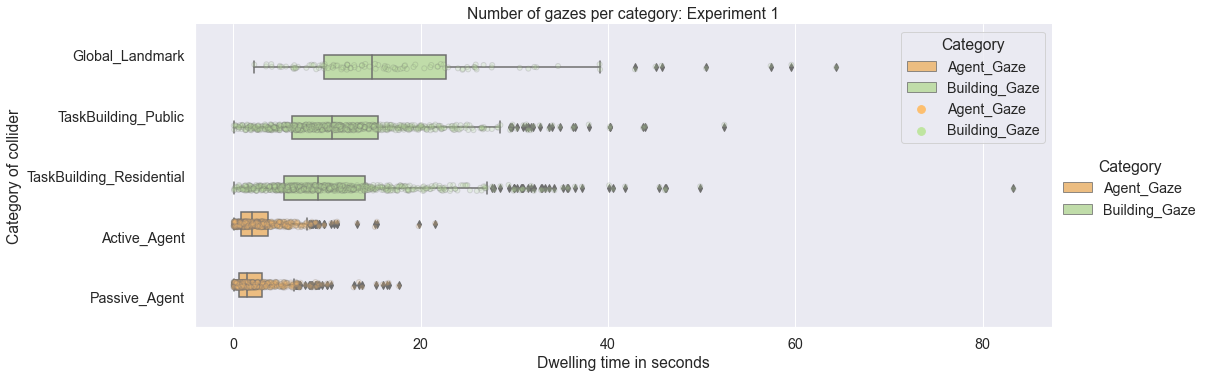

In [82]:
sns.catplot(y="Collider_CategoricalN", x="Dwelling_Time", hue='Category',  order= Fixation_Dwelling_Time.index.values, data=Fixations, \
            height=5, aspect=3, kind='box', palette="Spectral")
ax = sns.stripplot(y="Collider_CategoricalN", x="Dwelling_Time",hue='Category',   order= Fixation_Dwelling_Time.index.values, data=Fixations, \
                   alpha=0.2, dodge=True,linewidth=1,edgecolor='gray', palette="Spectral").set(title="Number of gazes per category: Experiment 1", xlabel="Dwelling time in seconds", ylabel= "Category of collider")

In [60]:
Agent_Fixation = Fixations[Fixations.Category == "Agent_Gaze"]
Building_Fixation = Fixations[Fixations.Category == "Building_Gaze"]
Building_Fixation = Building_Fixation[Building_Fixation.recoded != 'Crane_59'].copy()

In [61]:
Fixations

,SubjectID,recoded,Collider_CategoricalN,Dwelling_Time,Fixation_Count,avatar_ID,Category
0,365,01_Cma,Active_Agent,0.999441,5,1,Agent_Gaze
1,365,02_Cma,Active_Agent,2.241917,8,2,Agent_Gaze
2,365,05_Cma,Active_Agent,0.255441,2,5,Agent_Gaze
3,365,06_Cma,Active_Agent,4.235831,19,6,Agent_Gaze
4,365,07_Cma,Active_Agent,1.380368,6,7,Agent_Gaze
...,...,...,...,...,...,...,...
2947,9601,TaskBuilding_6,TaskBuilding_Residential,19.694432,93,31,Building_Gaze
2948,9601,TaskBuilding_7,TaskBuilding_Residential,5.850799,31,32,Building_Gaze
2949,9601,TaskBuilding_8,TaskBuilding_Public,9.518699,44,10,Building_Gaze
2950,9601,TaskBuilding_9,TaskBuilding_Public,8.078908,44,7,Building_Gaze


In [62]:
Agent_wide_Fixations = Agent_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Building_wide_Fixations = Building_Fixation.pivot(index=["SubjectID", 'avatar_ID'], columns='Category', values=["Dwelling_Time", "Fixation_Count"])
Agent_wide_Fixations.reset_index(inplace=True)
Building_wide_Fixations.reset_index(inplace=True)

In [63]:
Agent_wide_Fixations.columns = ['_'.join(col) for col in Agent_wide_Fixations.columns]
Building_wide_Fixations.columns = ['_'.join(col) for col in Building_wide_Fixations.columns]
Agent_wide_Fixations

,SubjectID_,avatar_ID_,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze
0,365,1,0.999441,5.0
1,365,2,2.241917,8.0
2,365,5,0.255441,2.0
3,365,6,4.235831,19.0
4,365,7,1.380368,6.0
...,...,...,...,...
1385,9601,51,6.200965,27.0
1386,9601,52,1.078302,5.0
1387,9601,53,0.376387,2.0
1388,9601,54,0.388366,2.0


In [64]:
Agent_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)
Building_wide_Fixations.rename({"SubjectID_":"SubjectID", "avatar_ID_":"avatar_ID"}, inplace=True, axis=1)

In [65]:
wide_Fixations = Building_wide_Fixations.merge(Agent_wide_Fixations, on=["SubjectID", "avatar_ID"])
wide_Fixations


,SubjectID,avatar_ID,Dwelling_Time_Building_Gaze,Fixation_Count_Building_Gaze,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze
0,365,1,12.048333,60.0,0.999441,5.0
1,365,2,4.683234,20.0,2.241917,8.0
2,365,5,0.424187,1.0,0.255441,2.0
3,365,6,11.538924,54.0,4.235831,19.0
4,365,7,8.279220,38.0,1.380368,6.0
...,...,...,...,...,...,...
1358,9601,51,21.986085,114.0,6.200965,27.0
1359,9601,52,10.778504,62.0,1.078302,5.0
1360,9601,53,6.379526,29.0,0.376387,2.0
1361,9601,54,5.136893,22.0,0.388366,2.0


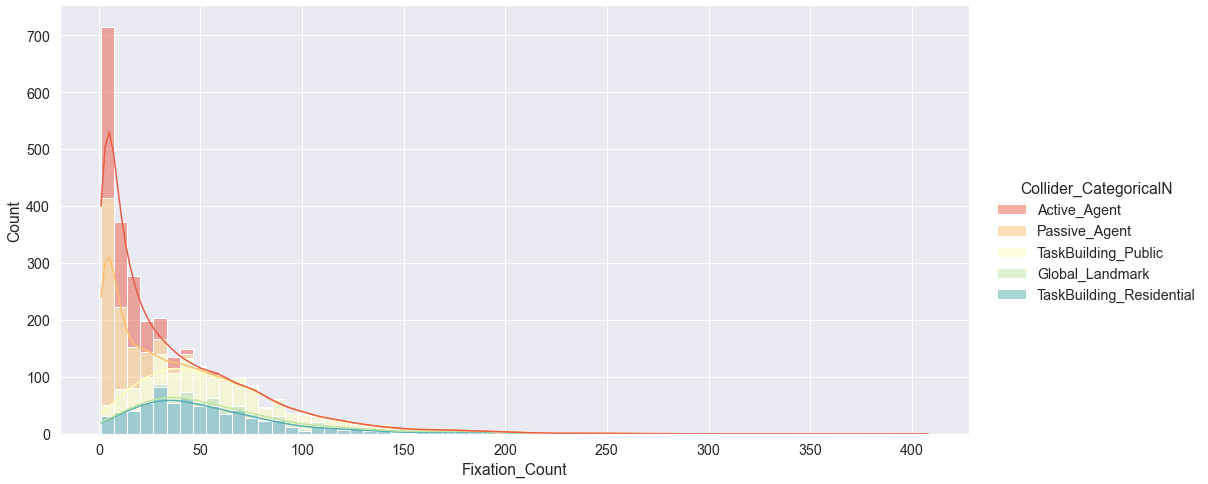

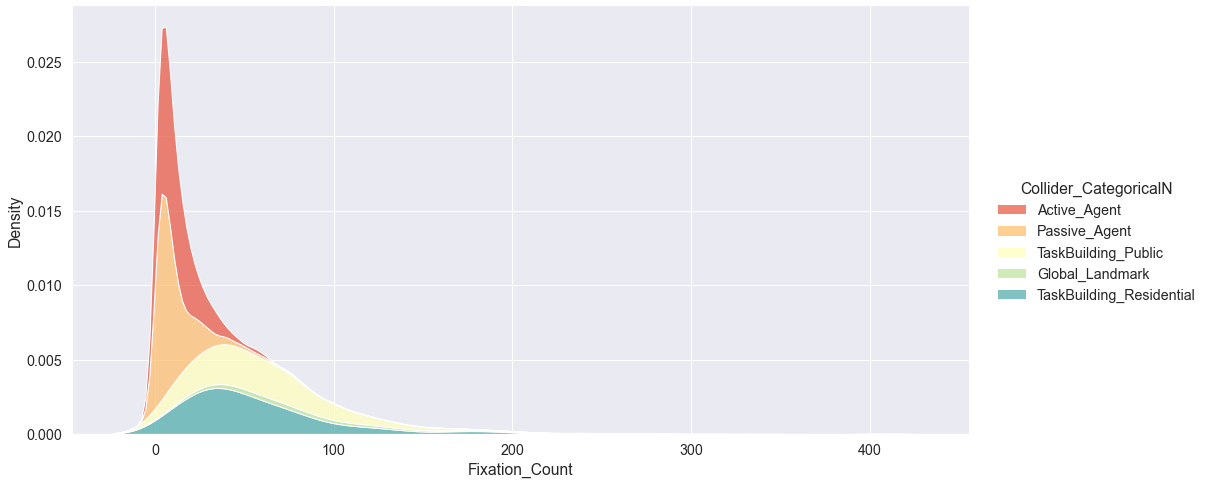

In [66]:
sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kde=True, palette="Spectral", multiple="stack")

sns.displot(x='Fixation_Count', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kind="kde", palette="Spectral", multiple="stack")

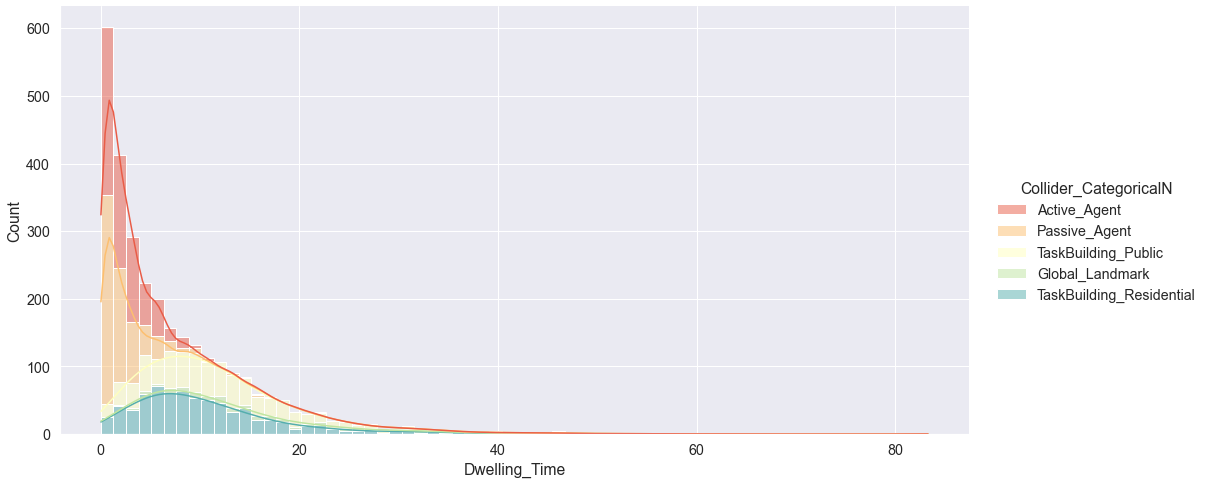

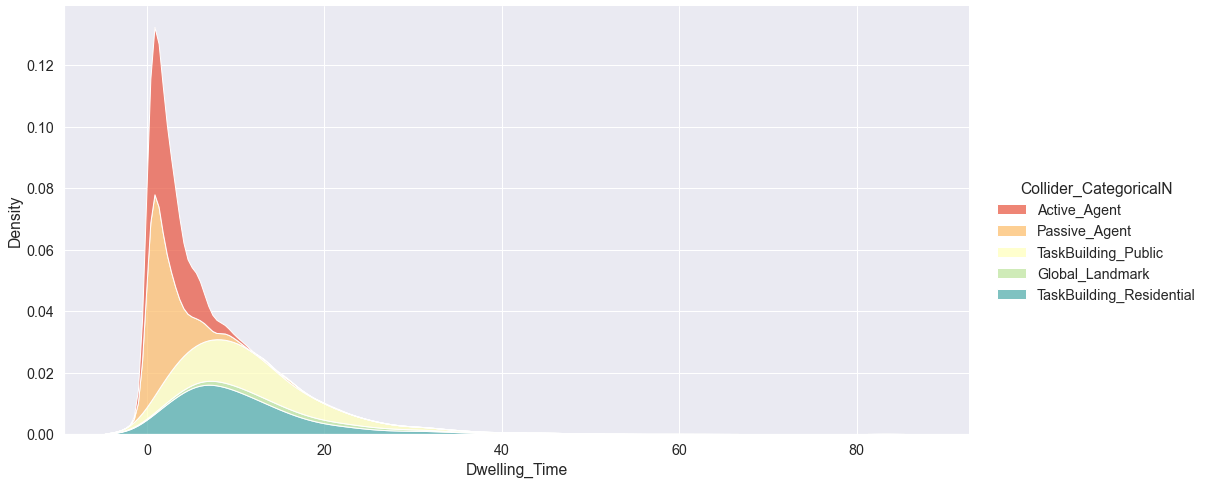

In [67]:
sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kde=True, palette="Spectral", multiple="stack")

sns.displot(x='Dwelling_Time', hue="Collider_CategoricalN",
             data=Fixations, 
            height=7, aspect= 2, kind="kde", palette="Spectral", multiple="stack")

In [68]:
Fixations.columns

Index(['SubjectID', 'recoded', 'Collider_CategoricalN', 'Dwelling_Time',
       'Fixation_Count', 'avatar_ID', 'Category'],
      dtype='object')

In [84]:
BehavioralData_Fixations_Wide


,Unnamed: 0,SubjectID,AbsolutError,SignedAngle-+180,IQR,RT,DistanceToParticipant,PointingTaskStartingLocations,TrialNumber,StartPointID,...,avatar_ID,AvatarPresenceCategory,Context,meaningfulBuilding,ImageName,Dwelling_Time_Building_Gaze,Fixation_Count_Building_Gaze,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze,Agent_Action_level
0,0,365,15.396716,15.396716,63.921884,25.825715,197.768723,21,1,1,...,46,Present,False,Not meaningful,46_Sa,37.230251,186.0,3.428844,12.0,Passive
1,1,365,6.037733,-6.037733,63.921884,4.799789,213.475525,16,78,7,...,46,Omitted,False,Not meaningful,46_SaNo,37.230251,186.0,3.428844,12.0,Passive
2,2,365,6.345290,6.345290,63.921884,4.638590,111.623512,13,88,8,...,46,Present,False,Not meaningful,46_Sa,37.230251,186.0,3.428844,12.0,Passive
3,3,365,3.627752,3.627752,63.921884,2.361455,111.623512,13,95,8,...,46,Omitted,False,Not meaningful,46_SaNo,37.230251,186.0,3.428844,12.0,Passive
4,4,365,19.115237,-19.115237,63.921884,5.975304,232.765823,8,131,11,...,46,Omitted,False,Not meaningful,46_SaNo,37.230251,186.0,3.428844,12.0,Passive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043,10043,9601,74.369573,-74.369573,48.844684,13.249648,271.054443,4,50,5,...,53,Omitted,False,Not meaningful,53_SaNo,6.379526,29.0,0.376387,2.0,Passive
10044,10044,9601,102.487607,-102.487607,48.844684,13.332483,514.466797,10,115,10,...,53,Present,False,Not meaningful,53_Sa,6.379526,29.0,0.376387,2.0,Passive
10045,10045,9601,42.251951,42.251951,48.844684,3.400082,706.590820,5,292,25,...,53,Omitted,False,Not meaningful,53_SaNo,6.379526,29.0,0.376387,2.0,Passive
10046,10046,9601,40.642620,40.642620,48.844684,2.924416,706.590820,5,297,25,...,53,Present,False,Not meaningful,53_Sa,6.379526,29.0,0.376387,2.0,Passive


In [69]:
Behavioral = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Pointing_Task/Results/PointingSummary_1_exp1.csv")

In [70]:
Behavioral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10048 entries, 0 to 10047
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10048 non-null  int64  
 1   ID                             10048 non-null  int64  
 2   AbsolutError                   10048 non-null  float64
 3   SignedAngle-+180               10048 non-null  float64
 4   IQR                            10048 non-null  float64
 5   RT                             10048 non-null  float64
 6   DistanceToParticipant          10048 non-null  float64
 7   PointingTaskStartingLocations  10048 non-null  int64  
 8   TrialNumber                    10048 non-null  int64  
 9   StartPointID                   10048 non-null  int64  
 10  ID_for_StartingPosition        10048 non-null  int64  
 11  avatarID                       10048 non-null  int64  
 12  AvatarPresenceCategory         10048 non-null 

In [71]:
Behavioral.rename({"ID":"SubjectID", "avatarID":"avatar_ID"}, axis=1, inplace=True)
Behavioral

,Unnamed: 0,SubjectID,AbsolutError,SignedAngle-+180,IQR,RT,DistanceToParticipant,PointingTaskStartingLocations,TrialNumber,StartPointID,ID_for_StartingPosition,avatar_ID,AvatarPresenceCategory,Context,meaningfulBuilding,ImageName
0,0,365,15.396716,15.396716,63.921884,25.825715,197.768723,21,1,1,1,46,Present,False,Not meaningful,46_Sa
1,1,365,6.037733,-6.037733,63.921884,4.799789,213.475525,16,78,7,6,46,Omitted,False,Not meaningful,46_SaNo
2,2,365,6.345290,6.345290,63.921884,4.638590,111.623512,13,88,8,4,46,Present,False,Not meaningful,46_Sa
3,3,365,3.627752,3.627752,63.921884,2.361455,111.623512,13,95,8,11,46,Omitted,False,Not meaningful,46_SaNo
4,4,365,19.115237,-19.115237,63.921884,5.975304,232.765823,8,131,11,11,46,Omitted,False,Not meaningful,46_SaNo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043,10043,9601,74.369573,-74.369573,48.844684,13.249648,271.054443,4,50,5,2,53,Omitted,False,Not meaningful,53_SaNo
10044,10044,9601,102.487607,-102.487607,48.844684,13.332483,514.466797,10,115,10,7,53,Present,False,Not meaningful,53_Sa
10045,10045,9601,42.251951,42.251951,48.844684,3.400082,706.590820,5,292,25,4,53,Omitted,False,Not meaningful,53_SaNo
10046,10046,9601,40.642620,40.642620,48.844684,2.924416,706.590820,5,297,25,9,53,Present,False,Not meaningful,53_Sa


In [72]:
BehavioralData_Fixations_Wide = Behavioral.merge(wide_Fixations, on=["SubjectID", "avatar_ID"], how="left")
BehavioralData_Fixations_Wide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10048 entries, 0 to 10047
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10048 non-null  int64  
 1   SubjectID                      10048 non-null  int64  
 2   AbsolutError                   10048 non-null  float64
 3   SignedAngle-+180               10048 non-null  float64
 4   IQR                            10048 non-null  float64
 5   RT                             10048 non-null  float64
 6   DistanceToParticipant          10048 non-null  float64
 7   PointingTaskStartingLocations  10048 non-null  int64  
 8   TrialNumber                    10048 non-null  int64  
 9   StartPointID                   10048 non-null  int64  
 10  ID_for_StartingPosition        10048 non-null  int64  
 11  avatar_ID                      10048 non-null  int64  
 12  AvatarPresenceCategory         10048 non-null 

In [230]:
BehavioralData_Fixations_Wide["Agent_Category"] = np.where(BehavioralData_Fixations_Wide.avatar_ID > 28, "Passive", "Active")

In [231]:
BehavioralData_Fixations_Wide.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv")

In [75]:
BehavioralData_Fixations_Wide[['Dwelling_Time_Agent_Gaze', 'Dwelling_Time_Building_Gaze',
       'Fixation_Count_Agent_Gaze', 'Fixation_Count_Building_Gaze',  'AbsolutError' ]].corr().style.background_gradient(cmap="Spectral")

,Dwelling_Time_Agent_Gaze,Dwelling_Time_Building_Gaze,Fixation_Count_Agent_Gaze,Fixation_Count_Building_Gaze,AbsolutError
Dwelling_Time_Agent_Gaze,1.000000,0.288306,0.968644,0.306871,-0.019623
Dwelling_Time_Building_Gaze,0.288306,1.000000,0.272011,0.980471,-0.095942
Fixation_Count_Agent_Gaze,0.968644,0.272011,1.000000,0.299203,-0.025608
Fixation_Count_Building_Gaze,0.306871,0.980471,0.299203,1.000000,-0.094221
AbsolutError,-0.019623,-0.095942,-0.025608,-0.094221,1.000000


In [77]:
data_frame_gaze_no_out_ONLY_TEST.groupby([ "Hit_Object_Category", "Session"])["length"].agg(['median','count','mean','std','max', 'min'])

median  count      mean       std       max  \
Hit_Object_Category Session                                                  
Agent               1        0.166659   4236  0.205879  0.135120  0.577841   
                    2        0.166657   4287  0.202798  0.135709  0.577839   
                    3        0.177568   3057  0.210406  0.137584  0.577843   
                    4        0.177568   2615  0.210278  0.134870  0.577840   
                    5        0.166656   2370  0.200999  0.133153  0.577842   
Background          1        0.205096     36  0.199505  0.115279  0.466737   
                    2        0.133921     33  0.188330  0.124246  0.576846   
                    3        0.152272     29  0.187515  0.128058  0.530720   
                    4        0.172608     72  0.199604  0.133036  0.568332   
                    5        0.157722     52  0.178818  0.125643  0.518816   
Building            1        0.154256  14238  0.184199  0.124007  0.577842   
                    2        0.155248  13847  0.186435  0.123797  0.577846   
                    3        0.155248  13141  0.187406  0.125000  0.577845   
                    4        0.155745  12181  0.189448  0.124541  0.577841   
                    5        0.155744  12714  0.187810  0.125344  0.577841   
Global_Landmark     1        0.166160   2438  0.199005  0.131572  0.577347   
                    2        0.167153   2029  0.198553  0.130240  0.577344   
                    3        0.177072   2053  0.201332  0.128277  0.576848   
                    4        0.177568   1810  0.204511  0.131344  0.577839   
                    5        0.166655   1672  0.196773  0.129872  0.577840   
Graffity            1        0.183272   4150  0.211587  0.135391  0.577840   
                    2        0.188479   4256  0.215534  0.136222  0.577843   
                    3        0.178065   3695  0.208983  0.134376  0.577840   
                    4        0.188478   3134  0.218110  0.137540  0.577840   
                    5        0.187969   2999  0.213617  0.133442  0.577839   

                                  min  
Hit_Object_Category Session            
Agent               1        0.032736  
                    2        0.013394  
                    3        0.011407  
                    4        0.032239  
                    5        0.026783  
Background          1        0.043152  
                    2        0.045633  
                    3        0.044144  
                    4        0.042159  
                    5        0.042159  
Building            1        0.010912  
                    2        0.009919  
                    3        0.010417  
                    4        0.008927  
                    5        0.010911  
Global_Landmark     1        0.011408  
                    2        0.010912  
                    3        0.010914  
                    4        0.011407  
                    5        0.010911  
Graffity            1        0.021824  
                    2        0.021824  
                    3        0.033231  
                    4        0.032737  
                    5        0.032737

In [ ]:
summary_name_stats_fix_length_NS_Agent.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/summary_name_stats_fix_length_NS_Agent.csv")

In [ ]:
summary_name_stats_fix_length_NS = pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID", "avatarID", "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [ ]:
summary_name_stats_fix_length_NS.reset_index(inplace=True)

In [ ]:
summary_name_stats_fix_length_NS

In [ ]:
summary_name_stats_fix_length_NS_Agent = summary_name_stats_fix_length_NS[summary_name_stats_fix_length_NS.Hit_Object_Category == 'Agent'].copy()
summary_name_stats_fix_length_NS_Agent['Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Collider_CategoricalN'].str.contains('Active')
summary_name_stats_fix_length_NS_Agent.loc[:, 'Agent_Category'] = summary_name_stats_fix_length_NS_Agent['Agent_Category'].replace({True: 'Active', False: 'Passive'})

In [ ]:
summary_name_stats_fix_length_NS_Agent

In [ ]:
Complete = pd.merge(HumanA, summary_name_stats_fix_length_NS,
                                 left_on= ['ID','avatarID'],
                                 right_on=['SubjectID','avatarID'],
                   how="right")

In [ ]:
Complete.tail(50)

In [ ]:
Complete.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Gaze_data_long.csv")

In [ ]:
Complete.shape

In [ ]:
HumanA.shape

In [ ]:
summary_name_stats_fix_length_NS.names.unique()

In [ ]:
summary_name_stats_fix_length.shape

In [ ]:
summary_stats_fix_length = pd.DataFrame(data_frame_gaze_no_out.groupby(["Collider_CategoricalN", "SubjectID", "Session"])["length"].agg(['count','mean','median','std','max', 'min']))
summary_stats_fix_length.reset_index(inplace=True)

In [ ]:
summary_name_stats_fix_length_BIG= pd.DataFrame(data_frame_gaze_no_out_ONLY_TEST.groupby([ "SubjectID", "Hit_Object_Category", "Collider_CategoricalN","Session" ])["length"].agg(['count','mean','median','std','max', 'min']))

In [ ]:
summary_name_stats_fix_length_BIG.reset_index(inplace=True)
summary_name_stats_fix_length_BIG.head(20)

In [ ]:
summary_name_stats_fix_length_BIG.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Grouped_Gazes.cvs")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Median length of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="median", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[(summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Hit_Object_Category", y="count", hue="Session", data=summary_name_stats_fix_length_BIG[summary_name_stats_fix_length_BIG.Hit_Object_Category == "Agent"], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/counts.png',  bbox_inches='tight')

In [ ]:
dy='Hit_Object_Category'; dx='count'; ort='h'; pal = sns.color_palette(); sigma = .2
f, ax = plt.subplots(figsize=(18, 15))

import ptitprince as pt

ax=pt.half_violinplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, bw = .2, cut = 0.,
                      scale = 'area', width = .6, inner = None, orient = ort)
ax=sns.stripplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, palette = pal, edgecolor = 'white',
                 size = 3, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot(x = dx, y = dy, data = summary_name_stats_fix_length_BIG, color = 'black', width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', 'zorder':10},\
            showfliers=True, whiskerprops = {'linewidth':2, 'zorder':10},\
            saturation = 1, orient = ort) 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="count", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=3, kind='box').set(title="Number of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="count",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=100)
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/count_Faces.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_Faces.png',  bbox_inches='tight')

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.tail()

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.columns

In [ ]:
data_frame_gaze_no_out_ONLY_TEST.groupby(["SubjectID", "SessionSubsection"])['']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="median", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=6, aspect=3, kind='box').set(title="Median gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="median",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/Median_Duration_All.png',  bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="max", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
            height=5, aspect=4, kind='box').set(title="Maximal duration of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="max",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Active_Agent_Face")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent")|(summary_stats_fix_length.Collider_CategoricalN == "Passive_Agent_Face")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="std", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=5, aspect=4, kind='box').set(title="Standard Deviation of gaze duration per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="std",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
ax.get_legend().remove()
ax.set_ylabel("Standard Deviation of gaze duration")
plt.savefig('/Users/tracysanchezpacheco/Desktop/MedianDurationFaces.png', bbox_inches='tight')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("flare")
sns.catplot(x="Collider_CategoricalN", y="min", hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
            height=7, aspect=4, kind='box').set(title="Minimum duration duration of gazes per session")
ax = sns.stripplot(x="Collider_CategoricalN", y="min",  hue="Session", data=summary_stats_fix_length[(summary_stats_fix_length.Collider_CategoricalN != "Background")&(summary_stats_fix_length.Collider_CategoricalN != "Building")], \
                   alpha=0.5, dodge=True,linewidth=1,edgecolor='gray')
#plt.ylim(top=1)
ax.get_legend().remove()
ax.set_ylabel("Minimum duration of gazes per session")
plt.savefig('/Users/tracysanchezpacheco/Desktop/count.png', bbox_inches='tight')

In [ ]:
HumanA = pd.read_csv("/Users/tracysanchezpacheco/Documents/Resources/humanA_Behavioural.csv")

In [ ]:
HumanA["AE_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.AbsolutError - np.nanmedian(HumanA.AbsolutError))) * 1.4826
HumanA["AE_mad_z"] = abs(HumanA.AbsolutError.tolist() - np.nanmedian(HumanA.AbsolutError)) / HumanA.AE_Median_Standard_Duration.tolist()
HumanA["Outlier_AE_Length"] = np.where(HumanA["AE_mad_z"] > 3.5, "Out", "Stays")
HumanA["RT_Median_Standard_Duration"] = np.nanmedian(abs(HumanA.RT - np.nanmedian(HumanA.RT))) * 1.4826
HumanA["RT_mad_z"] = abs(HumanA.RT.tolist() - np.nanmedian(HumanA.RT)) / HumanA.RT_Median_Standard_Duration.tolist()
HumanA["Outlier_RT_Length"] = np.where(HumanA["RT_mad_z"] > 3.5, "Out", "Stays")
HumanA_OUT = HumanA[(HumanA.Outlier_AE_Length != "Out") & (HumanA.Outlier_RT_Length != "Out")]
HumanA_OUT.to_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/HumanA_NoOut.cvs")

In [ ]:
data_frame.head(50)

In [ ]:
data_frame.info()

In [ ]:
data_frame.to_csv("/Volumes/SSD/00_Data_Processing/Pre_processed/Complete_Data_AngularV.cvs")

In [ ]:
One_participant.columns

In [ ]:
One_participant.drop(columns=['Unnamed: 0', 'level_0','Unnamed: 0.1', 'Unnamed: 0.1.1'], inplace=True)

In [ ]:
One_participant.events.value_counts()

In [ ]:
One_participant['avg_shift'] = One_participant['avg_dist'].shift(1) != One_participant['avg_dist']

In [ ]:
data_frame.iloc[115318:115322,6:9]

In [ ]:
data_frame.info()

In [ ]:
One_participant.iloc[115521:115532,45:50]

In [ ]:
One_participant.iloc[115318:115322,6]

In [ ]:
One_participant.iloc[115322,6] - One_participant.iloc[115318,6]

In [ ]:
One_participant.iloc[115532,6] - One_participant.iloc[115521,6]

In [ ]:
One_participant.tail(200)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
df